# Quality control of WEAVE RSS files

Wavelength calibration test

Based on sky emission lines identified in Row-stacked spectra (RSS)

# 0. Initialisation

## Imports

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import AutoMinorLocator

import numpy as np
import os
import glob

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as c
from astropy.table import Table


## Ancillary data

UVES sky emission atlas: <https://www.eso.org/observing/dfo/quality/UVES/pipeline/sky_spectrum.html>

In [2]:
wave_flux = np.empty((0, 2))
filenames = glob.glob('sky/UVES_sky_emission_atlas/gident_*.dat')
filenames.sort()
for filename in filenames:
    print(filename)
    wave_flux = np.concatenate((wave_flux, np.loadtxt(filename, usecols=(1, 4), skiprows=3, comments=['#', '--------'])), axis=0)
UVES_atlas = Table(wave_flux, names=('wavelength', 'flux'))

sky/UVES_sky_emission_atlas/gident_346.dat
sky/UVES_sky_emission_atlas/gident_437.dat
sky/UVES_sky_emission_atlas/gident_580L.dat
sky/UVES_sky_emission_atlas/gident_580U.dat
sky/UVES_sky_emission_atlas/gident_800U.dat
sky/UVES_sky_emission_atlas/gident_860L.dat
sky/UVES_sky_emission_atlas/gident_860U.dat


## RSS files

In [3]:
class WEAVE_RSS(object):
    
    def __init__(self, filename):
        '''Read a WEAVE "single exposure" file (i.e. row-stacked spectra for just one arm)'''
        self.filename = filename
        self.hdu = fits.open(filename)
        self.wcs = WCS(self.hdu[1].header)
        pixels = np.arange(self.hdu[1].data.shape[1])
        self.wavelength = self.wcs.spectral.pixel_to_world(pixels).to_value(u.Angstrom)
        self.counts = self.hdu[3].data
        self.counts_error = np.where(self.hdu[4].data > 0, 1/np.sqrt(self.hdu[4].data), np.nan)
        self.sky_counts = self.hdu[3].data - self.hdu[1].data
        self.sensitivity_function = self.hdu[5].data
        self.flux = self.hdu[1].data*self.sensitivity_function
        self.sky_sub_ivar = self.hdu[2].data
        
        bad = np.isnan(self.counts_error).nonzero()
        self.counts[bad] = np.nan
        self.sky_counts[bad] = np.nan
        self.sensitivity_function[bad] = np.nan
        self.flux[bad] = np.nan
        self.sky_sub_ivar[bad] = np.nan
        
        self.fibtable = self.hdu[6].data
        self.sky_fibres = np.where(self.fibtable['TARGUSE'] == 'S')
        self.target_fibres = np.where(self.fibtable['TARGUSE'] == 'T')
        self.n_sky_fibres = self.sky_fibres[0].size

        heliocentric_correction = (1 + np.nanmean(self.fibtable['Helio_cor'])/3e5)
        wave = UVES_atlas['wavelength'] * heliocentric_correction
        inside = np.where((wave > self.wavelength[0]) & (wave < self.wavelength[-1]))
        self.sky_lines = UVES_atlas[inside].copy()
        self.sky_lines['wavelength'] *= heliocentric_correction


In [4]:
red_arm = WEAVE_RSS('SV/20230512_13/single_3005695.fit')
blue_arm = WEAVE_RSS('SV/20230512_13/single_3005696.fit')
rss_list = [blue_arm, red_arm]
rss = red_arm

/tmp/ipykernel_434296/3960184381.py:11: RuntimeWarning: divide by zero encountered in true_divide
  self.counts_error = np.where(self.hdu[4].data > 0, 1/np.sqrt(self.hdu[4].data), np.nan)
/tmp/ipykernel_434296/3960184381.py:11: RuntimeWarning: divide by zero encountered in true_divide
  self.counts_error = np.where(self.hdu[4].data > 0, 1/np.sqrt(self.hdu[4].data), np.nan)


In [5]:
rss.hdu.info()

Filename: SV/20230512_13/single_3005695.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     469   ()      
  1  RED_DATA      1 ImageHDU        72   (7341, 600)   float32   
  2  RED_IVAR      1 ImageHDU        72   (7341, 600)   float32   
  3  RED_DATA_NOSS    1 ImageHDU        72   (7341, 600)   float32   
  4  RED_IVAR_NOSS    1 ImageHDU        72   (7341, 600)   float32   
  5  RED_SENSFUNC    1 ImageHDU        22   (7341, 600)   float32   
  6  FIBTABLE      1 BinTableHDU    181   600R x 60C   ['1I', '1I', '20A', '1D', '1D', '1E', '1E', '1A', '30A', '1E', '1E', '15A', '1E', '1I', '30A', '1D', '1D', '1E', '30A', '1E', '1E', '1E', '1A', '40A', '12A', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1D', '1D', '1E', '1E', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E']   


In [6]:
#rss.hdu[0].header
#rss.sky_lines

In [7]:
rss.fibtable.columns

ColDefs(
    name = 'Nspec'; format = '1I'; null = -1
    name = 'FIBREID'; format = '1I'; null = -1
    name = 'CNAME'; format = '20A'
    name = 'FIBRERA'; format = '1D'; unit = 'deg'
    name = 'FIBREDEC'; format = '1D'; unit = 'deg'
    name = 'XPOSITION'; format = '1E'; unit = 'mm'
    name = 'YPOSITION'; format = '1E'; unit = 'mm'
    name = 'STATUS'; format = '1A'
    name = 'TARGID'; format = '30A'
    name = 'TARGX'; format = '1E'; unit = 'mm'
    name = 'TARGY'; format = '1E'; unit = 'mm'
    name = 'TARGSRVY'; format = '15A'
    name = 'ORIENTAT'; format = '1E'; unit = 'deg'
    name = 'RETRIES'; format = '1I'; null = -1
    name = 'TARGNAME'; format = '30A'
    name = 'TARGRA'; format = '1D'; unit = 'deg'
    name = 'TARGDEC'; format = '1D'; unit = 'deg'
    name = 'TARGEPOCH'; format = '1E'; unit = 'yr'
    name = 'TARGCAT'; format = '30A'
    name = 'TARGPMRA'; format = '1E'; unit = 'mas/yr'
    name = 'TARGPMDEC'; format = '1E'; unit = 'mas/yr'
    name = 'TARGPARAL'; fo

# 1. Raw counts and errors

## 2D plot

Text(0.5, 0, 'wavelength [$\\AA$]')

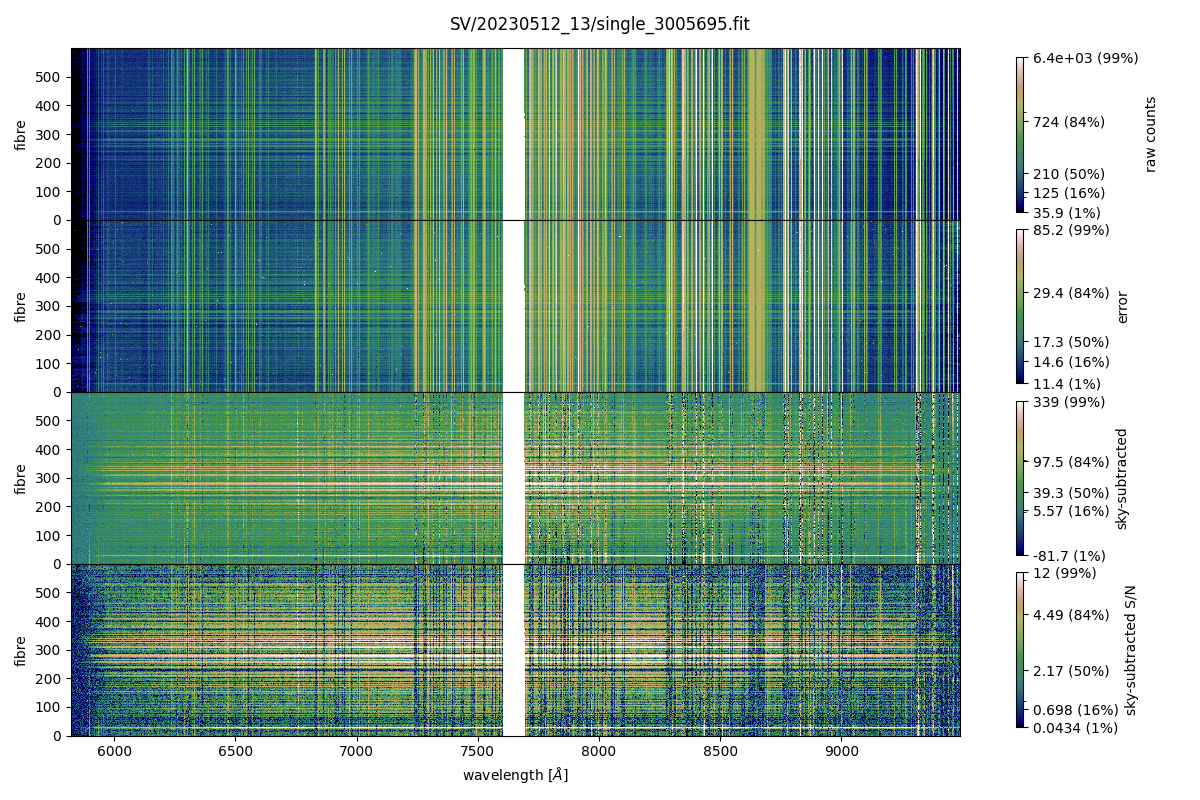

In [8]:
fig_name = 'counts_errors_2D'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 8))
axes = fig.subplots(nrows=4, ncols=1, squeeze=False,
                    sharex='col', sharey=True,
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(rss.filename)

def show_data(x, data, ax, title, angle=0):
    #percentiles = np.array([0, 16, 50, 84, 100])
    percentiles = np.array([1, 16, 50, 84, 99])
    ticks = np.nanpercentile(data, percentiles)
    median = ticks[np.argmin(np.abs(percentiles-50))]
    std = np.std(data[data < median])
    im = ax.imshow(data,
                   extent=(x[0], x[-1], -.5, data.shape[0]-.5),
                   interpolation='nearest', origin='lower',
                   #cmap='nipy_spectral',
                   #cmap='terrain',
                   #cmap='gist_stern',
                   #cmap='ocean',
                   cmap='gist_earth',
                   #norm=colors.SymLogNorm(vmin=median-3*std, vmax=ticks[-1], linthresh=median+3*std),
                   norm=colors.SymLogNorm(vmin=ticks[0], vmax=ticks[-1], linthresh=median+3*std),
                  )
    ax.set_aspect('auto')
    ax.set_ylabel('fibre')
    cb = fig.colorbar(im, ax=ax, orientation='vertical', shrink=.9)
    cb.ax.set_ylabel(title)
    cb.ax.set_yticks(ticks=ticks, labels=[f'{value:.3g} ({percent}%)' for value, percent in zip(ticks, percentiles)], rotation=angle)


show_data(rss.wavelength, rss.counts, axes[0, 0], 'raw counts')
show_data(rss.wavelength, rss.counts_error, axes[1, 0], 'error')
show_data(rss.wavelength, rss.counts-rss.sky_counts, axes[2, 0], 'sky-subtracted')
show_data(rss.wavelength, np.abs(rss.counts-rss.sky_counts)/rss.counts_error, axes[3, 0], 'sky-subtracted S/N')
#show_data(rss.wavelength, rss.flux, axes[2, 0], 'flux')

axes[-1, 0].set_xlabel(r'wavelength [$\AA$]')


## Values

In [9]:
sorted_counts = np.sort(rss.counts.ravel())
sorted_counts = sorted_counts[np.isfinite(sorted_counts)]
N_counts = sorted_counts.size
y_counts = np.arange(N_counts)
y_counts = (y_counts+1)*(N_counts-y_counts)/N_counts

In [10]:
sorted_err = np.sort(rss.counts_error.ravel())
sorted_err = sorted_err[np.isfinite(sorted_err)]
N_err = sorted_err.size
y_err = np.arange(N_err)
y_err = (y_err+1)*(N_err-y_err)/N_err

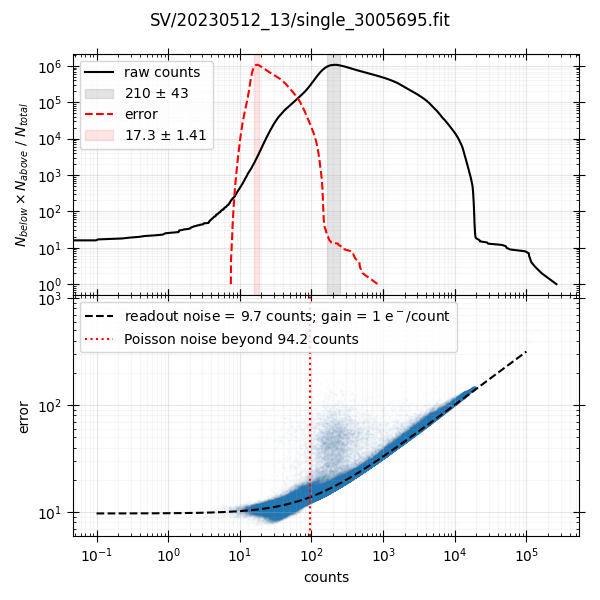

In [11]:
fig_name = 'counts_errors'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(6, 6))
axes = fig.subplots(nrows=2, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(rss.filename)
for ax in axes.flat:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
    ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
    ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
    ax.grid(True, which='both')


ax = axes[0, 0]
ax.set_ylabel(r'$N_{below} \times N_{above} ~/~ N_{total}$')
ax.set_yscale('log')

ax.plot(sorted_counts, y_counts, 'k-', label='raw counts')
'''
percentiles = np.array([0, 16, 50, 84, 100])
for per, val in zip(percentiles, sorted_counts[percentiles*(N_counts-1)//100]):
    ax.axvline(val, color='k', ls=':', label=f'{val:.4g} ({per}%)')
'''

median = sorted_counts[N_counts//2]
std = np.std(sorted_counts[:N_counts//2])
ax.axvspan(median-std, median+std, color='k', alpha=.1, label=f'{median:.3g} $\\pm$ {std:.3g}')
ax.legend()

ax.plot(sorted_err, y_err, 'r--', label='error')
'''
for per, val in zip(percentiles, sorted_err[percentiles*(N_err-1)//100]):
    ax.axvline(val, color='r', ls=':', label=f'{val:.4g} ({per}%)')
'''

median = sorted_err[N_err//2]
std = np.std(sorted_err[:N_err//2])
ax.axvspan(median-std, median+std, color='r', alpha=.1, label=f'{median:.3g} $\\pm$ {std:.3g}')
ax.legend(loc='upper left')


ax = axes[1, 0]
ax.set_ylabel(r'error')
ax.set_yscale('log')
ax.scatter(rss.counts.flat, rss.counts_error.flat, s=1, alpha=.01)

n_counts = np.logspace(-1, 5, 101)
electrons_per_count = 1  # initial guess
sigma_ron = np.sqrt(np.nanmedian((rss.counts_error**2 - rss.counts*electrons_per_count)))
electrons_per_count = np.sqrt(np.nanmedian((rss.counts_error**2 - sigma_ron**2)/rss.counts))
noise_transition = sigma_ron**2/electrons_per_count
ax.plot(n_counts, np.sqrt(sigma_ron**2 + electrons_per_count*n_counts), 'k--', label=f'readout noise = {sigma_ron:.3g} counts; gain = {electrons_per_count:.3g} e$^-$/count')
ax.axvline(noise_transition, c='r', ls=':', label=f'Poisson noise beyond {noise_transition:.3g} counts')

ax.legend(loc='upper left')


ax = axes[-1, 0]
ax.set_xlabel(r'counts')
ax.set_xscale('log')


# 2. Sky spectrum

## First guess

Just a median over the "sky fibres"

In [12]:
median_sky = np.nanmedian(rss.sky_counts[rss.sky_fibres], axis=0)

/home/yago/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


## Line Spread Function

Median:

In [13]:
def normalise(x):
    x -= np.median(x)
    norm = x[x.size//2]
    if norm > 0:
        x /= norm
    else:
        x *= np.nan
    return x


def find_LSF(delta_l, spectrum):
    median_skyline = np.zeros((rss.sky_lines['wavelength'].size, delta_l.size))
    for i, line in enumerate(rss.sky_lines['wavelength']):
        sed = np.interp(line+delta_l, rss.wavelength, spectrum)
        sed = normalise(sed)
        median_skyline[i] = sed
    return normalise(np.nanmedian(median_skyline, axis=0))


def find_FWHM(delta_l, profile):
    threshold = np.max(profile)/2
    left = np.max(delta_l[(delta_l < 0) & (profile < threshold)])
    right = np.min(delta_l[(delta_l > 0) & (profile < threshold)])
    return right-left


In [14]:
LSF_dlambda = np.linspace(-20, 20, 201)
median_sky_LSF = find_LSF(LSF_dlambda, median_sky)
median_sky_FWHM = find_FWHM(LSF_dlambda, median_sky_LSF)

Individual fibres:

In [15]:
fibre_LSF = np.empty((rss.n_sky_fibres, LSF_dlambda.size))
fibre_FWHM = np.empty(rss.n_sky_fibres)
for i, fibre in enumerate(rss.sky_fibres[0]):
    fibre_LSF[i] = find_LSF(LSF_dlambda, rss.counts[fibre])
    fibre_FWHM[i] = find_FWHM(LSF_dlambda, fibre_LSF[i])

In [58]:
high_res, low_res = np.nanpercentile(fibre_FWHM, [100/3, 200/3])
sky_high_res = np.nanmedian(rss.sky_counts[rss.sky_fibres][fibre_FWHM < high_res], axis=0)
sky_low_res = np.nanmedian(rss.sky_counts[rss.sky_fibres][fibre_FWHM > low_res], axis=0)
print(f'high and low resolution: FWHM < {high_res}, FWHM > {low_res} AA (median sky: {median_sky_FWHM})')

high and low resolution: FWHM < 3.1999999999999993, FWHM > 3.200000000000003 AA (median sky: 3.200000000000003)


/home/yago/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Plots:

Text(0.5, 0, '$(\\lambda - \\lambda_0)$ [$\\AA$]')

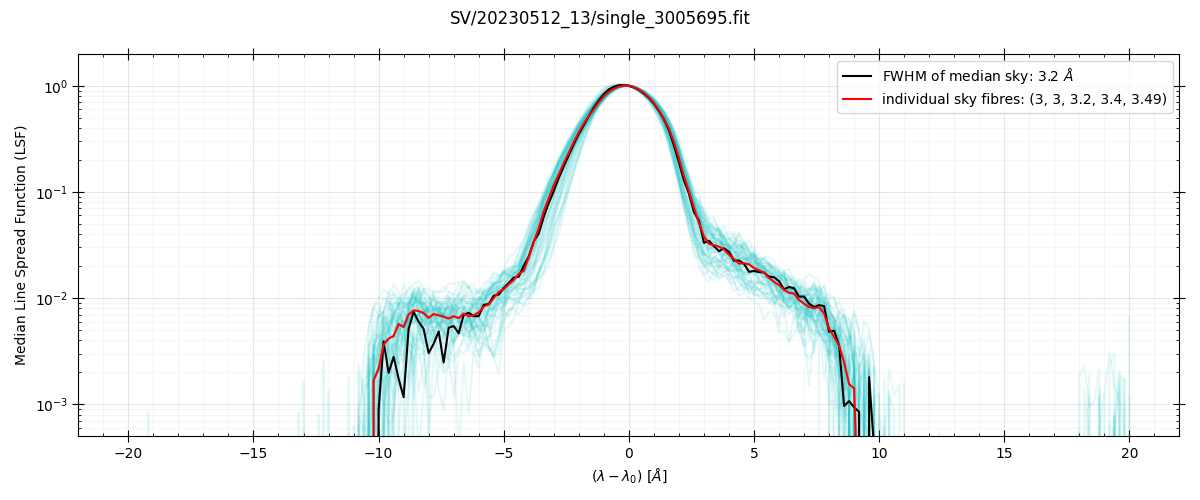

In [16]:
fig_name = 'LSF'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 5))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(rss.filename)
for ax in axes.flat:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
    ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
    ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
    ax.grid(True, which='both')

    
ax = axes[0, 0]
ax.set_ylabel(r'Median Line Spread Function (LSF)')
ax.set_yscale('log')
ax.set_ylim(5e-4, 2)

for fibre in range(rss.n_sky_fibres):
    ax.plot(LSF_dlambda, fibre_LSF[fibre], 'c-', alpha=.1)
ax.plot(LSF_dlambda, median_sky_LSF, 'k-', alpha=1, label=f'FWHM of median sky: {median_sky_FWHM:.3g} $\\AA$ ')
p1, p16, p50, p84, p99 = np.nanpercentile(fibre_FWHM, [1, 16, 50, 84, 99])
ax.plot(LSF_dlambda, np.nanmedian(fibre_LSF, axis=0), 'r-', alpha=1, label=f'individual sky fibres: ({p1:.3g}, {p16:.3g}, {p50:.3g}, {p84:.3g}, {p99:.3g})')
ax.legend()

ax = axes[-1, 0]
ax.set_xlabel(r'$(\lambda - \lambda_0)$ [$\AA$]')

## Peak finding

Convolution

In [17]:
resolution_boost = 8
model_wave = np.linspace(rss.wavelength[0], rss.wavelength[-1], resolution_boost*rss.wavelength.size)
dl = model_wave - np.mean(model_wave)
kernel = np.interp(dl, LSF_dlambda, np.nanmedian(fibre_LSF, axis=0))
kernel[np.isnan(kernel)] = 0
kernel *= np.exp(-(dl/median_sky_FWHM)**2)
kernel = np.fft.rfftn(kernel)

def find_peaks(spectrum):
    signal = np.interp(model_wave, rss.wavelength, spectrum)
    signal[np.isnan(signal)] = 0

    model = np.fft.rfftn(signal)
    model = np.fft.irfftn(model*np.absolute(kernel))/2/np.pi/resolution_boost
    peaks = np.empty_like(model_wave)
    peaks[1:-1] = np.where((model[1:-1] > model[:-2]) & (model[1:-1] > model[2:]), model[1:-1], 0)
    peaks[0] = peaks[-1] = 0
    
    return peaks


In [18]:
median_peaks = find_peaks(median_sky)

In [19]:
fibre_peaks = np.empty((rss.n_sky_fibres, model_wave.size))
for i, fibre in enumerate(rss.sky_fibres[0]):
    fibre_peaks[i] = find_peaks(rss.counts[fibre])

In [20]:
median_peak_wave = model_wave[median_peaks > 0]
median_peak_height = median_peaks[median_peaks > 0]

Matching/tracking peaks accross fibres

In [21]:
candidates = np.where(fibre_peaks > 0)
best_match_wave = np.zeros((median_peak_wave.size, rss.n_sky_fibres))
best_match_height = np.zeros((median_peak_wave.size, rss.n_sky_fibres))
for i, line in enumerate(median_peak_wave):
    distance = np.inf*np.ones_like(fibre_peaks)
    distance[candidates] = ((line - model_wave[candidates[1]]) / median_sky_FWHM)**2 #+ (np.log(median_peak_height[i]/fibre_peaks[candidates]) / .1)**2    
    match = np.argmin(distance, axis=1)
    best_match_wave[i] = model_wave[match]
    best_match_height[i] = fibre_peaks[np.arange(rss.n_sky_fibres), match]

Keep only "a few" robust" peaks (somewhat arbitrary)

In [22]:
median_peak_jitter = np.std(best_match_wave, axis=1)
p16, p50, p84 = np.nanpercentile(median_peak_jitter, [16, 50, 84])
jitter_threshold = p50
p16, p50, p84 = np.nanpercentile(median_peak_height, [16, 50, 84])
height_threshold = p50
good_peak = np.where((median_peak_jitter < jitter_threshold) & (median_peak_height > height_threshold))

## Wavelength calibration and fibre flat

Fit linear functions $a_i+b_i\lambda$ to wavelength corrections and fibre flat of each fibre $i$ as a function of wavelength

In [23]:
def fit_correction(wavelength, correction):
    lambda0 = np.nanmean(wavelength)

    left = np.where(wavelength < lambda0)
    lambda_left = np.nanmean(wavelength[left])
    correction_left = np.nanmedian(correction[left], axis=0)

    right = np.where(wavelength > lambda0)
    lambda_right = np.nanmean(wavelength[right])
    correction_right = np.nanmedian(correction[right], axis=0)
    
    slope  = (correction_right - correction_left) / (lambda_right - lambda_left)
    zero_point = correction_left - slope*lambda_left
    return zero_point, slope

fibre_flat_zero_point, fibre_flat_slope = fit_correction(median_peak_wave[good_peak], best_match_height[good_peak]/median_peak_height[good_peak][:, np.newaxis])
wavelength_correction_zero_point, wavelength_correction_slope = fit_correction(median_peak_wave[good_peak], best_match_wave[good_peak] - median_peak_wave[good_peak][:, np.newaxis])

Apply corrections (leave fancier interpolation as future work ;^D):

In [24]:
corrected_counts = rss.counts[rss.sky_fibres] / (fibre_flat_zero_point[:, np.newaxis] + fibre_flat_slope[:, np.newaxis]*rss.wavelength[np.newaxis, :])
corrected_wave = rss.wavelength - (wavelength_correction_zero_point[:, np.newaxis] + wavelength_correction_slope[:, np.newaxis]*rss.wavelength[np.newaxis, :])

for i in range(rss.n_sky_fibres):
    corrected_counts[i] = np.interp(rss.wavelength, corrected_wave[i], corrected_counts[i])

## Sky subtraction

In [72]:
high_res, low_res = np.nanpercentile(fibre_FWHM, [100/3, 200/3])
sky_high_res = np.nanmedian(corrected_counts[fibre_FWHM < high_res], axis=0)
sky_low_res = np.nanmedian(corrected_counts[fibre_FWHM > low_res], axis=0)
sky_mid_res = np.nanmedian(corrected_counts, axis=0)
print(f'high and low resolution: FWHM < {high_res}, FWHM > {low_res} AA (median sky: {median_sky_FWHM})')

high and low resolution: FWHM < 3.1999999999999993, FWHM > 3.200000000000003 AA (median sky: 3.200000000000003)


/home/yago/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [73]:
def get_sky(FWHM):
    w = np.clip((FWHM - high_res) / (low_res - high_res), 0, 1)
    w_high = 1 - w**2
    w_low = w**2
    w_med = 4*w*(1-w)
    return (w_high*sky_high_res + w_med*sky_mid_res + w_low*sky_low_res) / (w_high + w_med + w_low)

In [74]:
sky_subtracted = np.empty_like(corrected_counts)

for i in range(rss.n_sky_fibres):
    sky_subtracted[i] = corrected_counts[i] - get_sky(fibre_FWHM[i])

## Plot results

In [159]:
random_fibre = np.random.randint(0, rss.n_sky_fibres)
random_fibre = 42

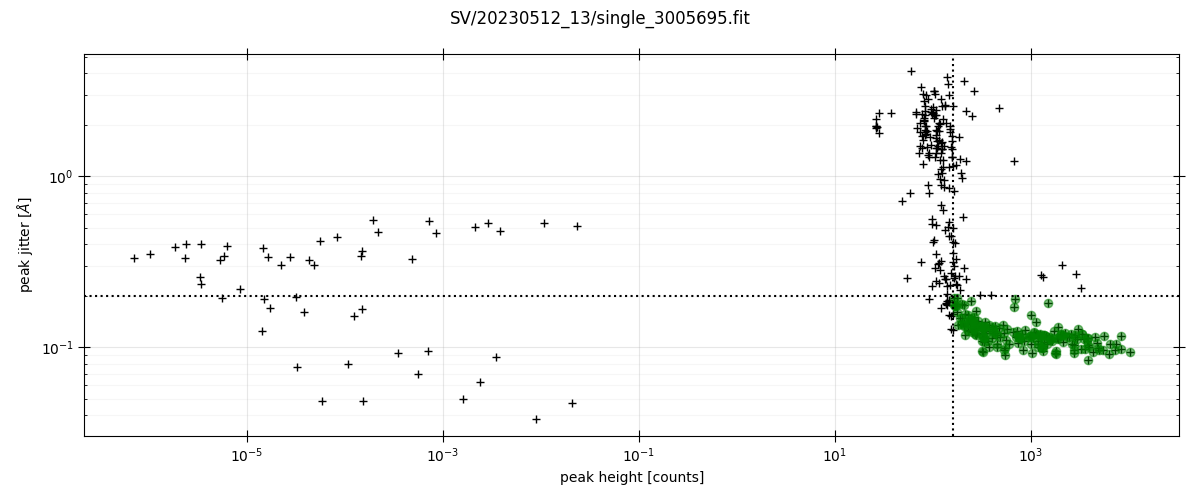

In [160]:
fig_name = 'good_peak_selection'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 5))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(rss.filename)
for ax in axes.flat:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
    ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
    ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
    ax.grid(True, which='both')

    
ax = axes[0, 0]
ax.set_ylabel(r'peak jitter [$\AA$]')
ax.set_yscale('log')

ax.plot(median_peak_height, median_peak_jitter, 'k+', alpha=1)
ax.plot(median_peak_height[good_peak], median_peak_jitter[good_peak], 'go', alpha=.5)
ax.axhline(jitter_threshold, c='k', ls=':')
ax.axvline(height_threshold, c='k', ls=':')

#ax = axes[-1, 0]
ax.set_xlabel('peak height [counts]')
ax.set_xscale('log')


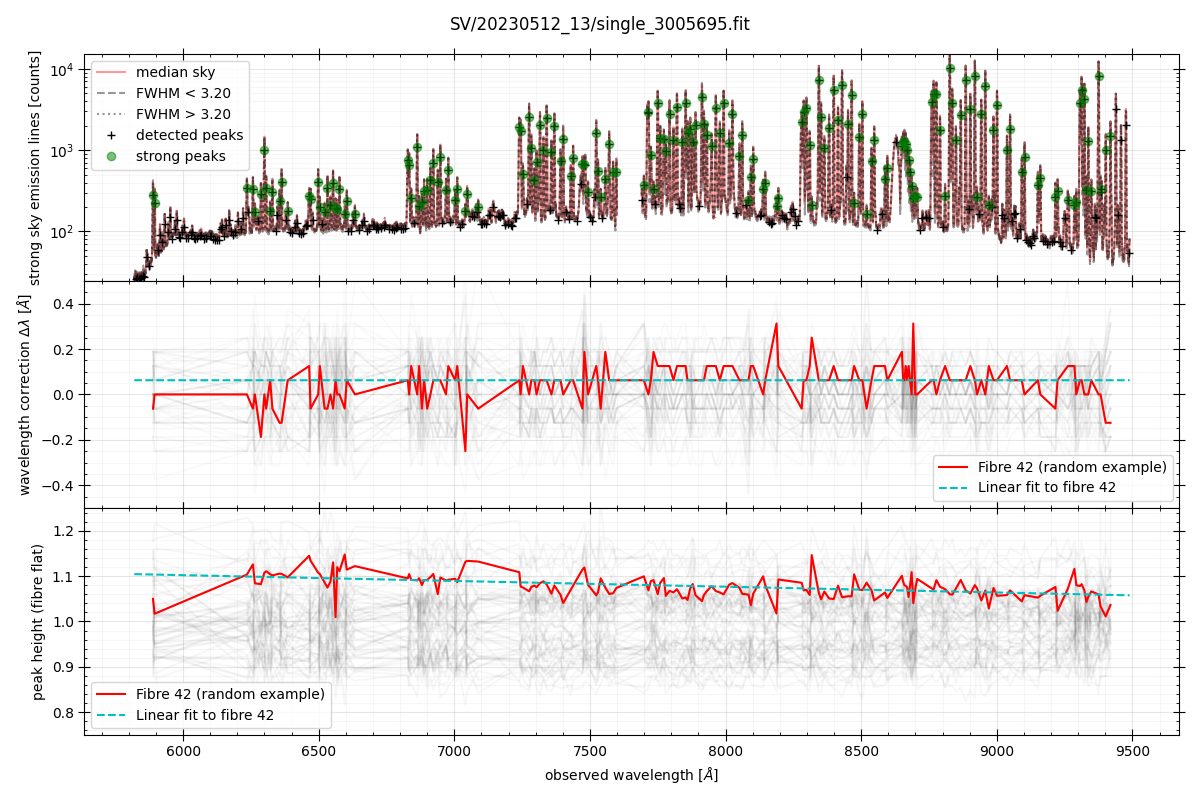

In [166]:
fig_name = 'corrections_1D'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 8))
axes = fig.subplots(nrows=3, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(rss.filename)
for ax in axes.flat:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
    ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
    ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
    ax.grid(True, which='both')

    
ax = axes[0, 0]
ax.set_ylabel(r'strong sky emission lines [counts]')
ax.set_yscale('log')
ax.set_ylim(np.nanmin(median_sky), np.nanmax(median_sky))

ax.plot(rss.wavelength, median_sky, 'r-', alpha=.4, label='median sky')
ax.plot(rss.wavelength, sky_high_res, 'k--', alpha=.4, label=f'FWHM < {high_res:.2f}')
ax.plot(rss.wavelength, sky_low_res, 'k:', alpha=.4, label=f'FWHM > {low_res:.2f}')

#ax.plot(LSF_dlambda, median_sky_LSF, 'k-', alpha=1, label=f'FWHM of median sky: {median_sky_FWHM:.3g} $\\AA$ ')
ax.plot(median_peak_wave, median_peak_height, 'k+', alpha=1, label='detected peaks')
ax.plot(median_peak_wave[good_peak], median_peak_height[good_peak], 'go', alpha=.5, label='strong peaks')
ax.legend()


ax = axes[1, 0]
ax.set_ylabel(r'wavelength correction $\Delta \lambda$ [$\AA$]')
#ax.set_yscale('log')
ax.set_ylim(-.5, .5)

for fibre in range(rss.n_sky_fibres):
    ax.plot(median_peak_wave[good_peak], (best_match_wave[good_peak, fibre] - median_peak_wave[good_peak]).flat, 'k-', alpha=.02)

ax.plot(median_peak_wave[good_peak], (best_match_wave[good_peak, random_fibre] - median_peak_wave[good_peak]).flat, 'r-', alpha=1,
       label=f'Fibre {random_fibre} (random example)')
ax.plot(rss.wavelength, wavelength_correction_zero_point[random_fibre] + wavelength_correction_slope[random_fibre]*rss.wavelength, 'c--',
       label=f'Linear fit to fibre {random_fibre}')
ax.legend()


ax = axes[2, 0]
ax.set_ylabel('peak height (fibre flat)')
#ax.set_yscale('log')
ax.set_ylim(.75, 1.25)

for fibre in range(rss.n_sky_fibres):
    ax.plot(median_peak_wave[good_peak], (best_match_height[good_peak, fibre] / median_peak_height[good_peak]).flat, 'k-', alpha=.03)

ax.plot(median_peak_wave[good_peak], (best_match_height[good_peak, random_fibre] / median_peak_height[good_peak]).flat, 'r-', alpha=1,
       label=f'Fibre {random_fibre} (random example)')
ax.plot(rss.wavelength, fibre_flat_zero_point[random_fibre] + fibre_flat_slope[random_fibre]*rss.wavelength, 'c--',
       label=f'Linear fit to fibre {random_fibre}')
ax.legend()


ax = axes[-1, 0]
ax.set_xlabel(r'observed wavelength [$\AA$]')
plt.savefig(f'{fig_name}.pdf')

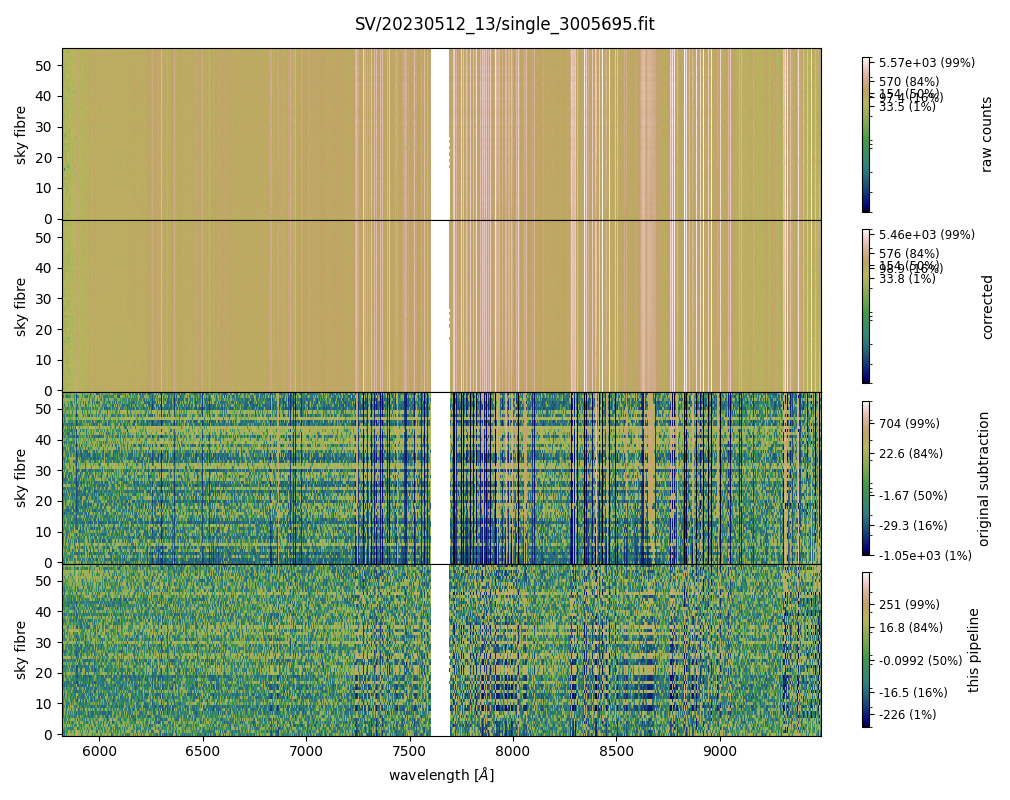

In [158]:
fig_name = 'corrections_2D'
plt.close(fig_name)

nrows = 4
ncols = 1
panel_width = 10
panel_height = 2
cbar_fraction = .01

fig = plt.figure(fig_name, figsize=(ncols*panel_width/(1-cbar_fraction), nrows*panel_height))
axes = fig.subplots(nrows=nrows, ncols=ncols, squeeze=False,
                    sharex=True, sharey=True,
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(rss.filename)

def show_data(x, data, ax, title, angle=0, cmap='nipy_spectral', norm=None):
    #percentiles = np.array([0, 16, 50, 84, 100])
    percentiles = np.array([1, 16, 50, 84, 99])
    ticks = np.nanpercentile(data, percentiles)
    median = ticks[np.argmin(np.abs(percentiles-50))]
    std = np.std(data[data < median])
    if norm is None:
        norm = colors.SymLogNorm(vmin=ticks[0], vmax=ticks[-1], linthresh=median+2*std)
    im = ax.imshow(data,
                   interpolation='nearest', origin='lower',
                   extent=(x[0], x[-1], -.5, data.shape[0]-.5),
                   cmap=cmap,
                   norm=norm,
                   #norm=colors.SymLogNorm(vmin=-1e3, vmax=1e3, linthresh=10),
                   #norm=colors.SymLogNorm(vmin=median-3*std, vmax=ticks[-1], linthresh=median+3*std),
                  )
    ax.set_aspect('auto')
    ax.set_ylabel('sky fibre')
    cb = fig.colorbar(im, ax=ax, orientation='vertical', shrink=.9, fraction=cbar_fraction)
    cb.ax.set_ylabel(title)
    cb.ax.set_yticks(ticks=ticks, labels=[f'{value:.3g} ({percent}%)' for value, percent in zip(ticks, percentiles)],
                     fontsize='small', rotation=angle)


#norm = colors.LogNorm(vmin=10, vmax=1e4)
norm = colors.SymLogNorm(vmin=-1e3, vmax=1e4, linthresh=5)
cmap = 'gist_heat'
cmap = 'gist_earth'

show_data(rss.wavelength, rss.counts[rss.sky_fibres], axes[0, 0], 'raw counts', cmap=cmap, norm=norm)
#ax = axes[0, 0]
#for peak in good_peak[0]:
#    ax.plot(best_match_wave[peak], np.arange(rss.n_sky_fibres), 'k-', alpha=.5)

show_data(rss.wavelength, corrected_counts, axes[1, 0], 'corrected', cmap=cmap, norm=norm)


show_data(rss.wavelength, rss.counts[rss.sky_fibres]-rss.sky_counts[0], axes[2, 0], 'original subtraction', cmap=cmap, norm=norm)
show_data(rss.wavelength, sky_subtracted, axes[3, 0], 'this pipeline', cmap=cmap, norm=norm)

axes[-1, 0].set_xlabel(r'wavelength [$\AA$]')
#axes[-1, 0].set_xlim(8900, 9100)

'''
for ax in axes.flat:
    for i in range(median_sky_bins.size-1):
        #ax.plot(fibre_flat_wave[:, i], np.arange(rss.sky_fibres[0].size), 'k-')
        ax.plot(median_sky_bin_wave[i]+delta_lambda, np.arange(rss.n_sky_fibres), 'k-')
'''
plt.savefig(f'{fig_name}.pdf')

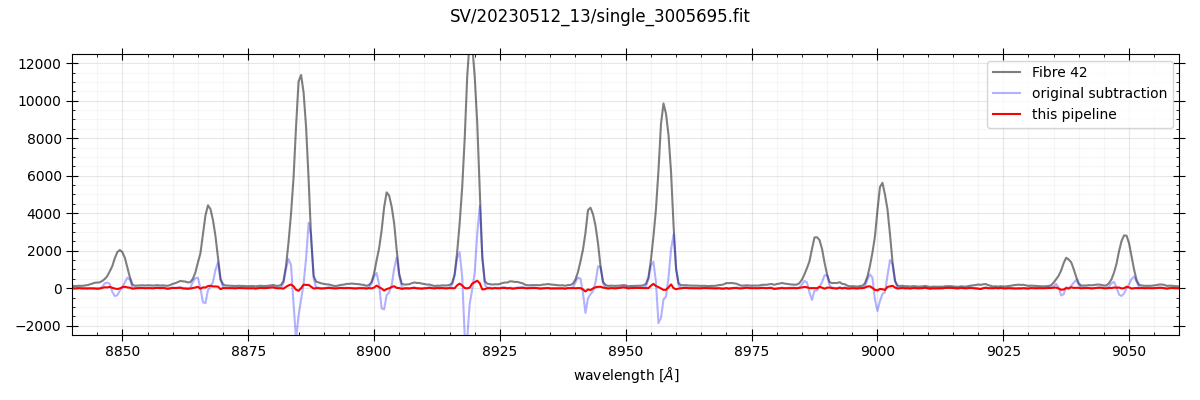

In [165]:
fig_name = 'sky_subtraction'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 4))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                    sharex='col', sharey=True,
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(rss.filename)
for ax in axes.flat:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
    ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
    ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
    ax.grid(True, which='both')


ax = axes[0, 0]
#ax.set_yscale('symlog', linthresh=1e3)
ax.set_ylim(-2.5e3, 1.25e4)
ax.plot(rss.wavelength, rss.counts[rss.sky_fibres][random_fibre], 'k-', alpha=.5, label=f'Fibre {random_fibre}')
ax.plot(rss.wavelength, rss.counts[rss.sky_fibres][random_fibre]-rss.sky_counts[0], 'b-', alpha=.3, label='original subtraction')
ax.plot(rss.wavelength, sky_subtracted[random_fibre], 'r-', alpha=1, label='this pipeline')
ax.legend()

axes[-1, 0].set_xlabel(r'wavelength [$\AA$]')
axes[-1, 0].set_xlim(8840, 9060)
plt.savefig(f'{fig_name}.pdf')

(0.0, 3000.0)

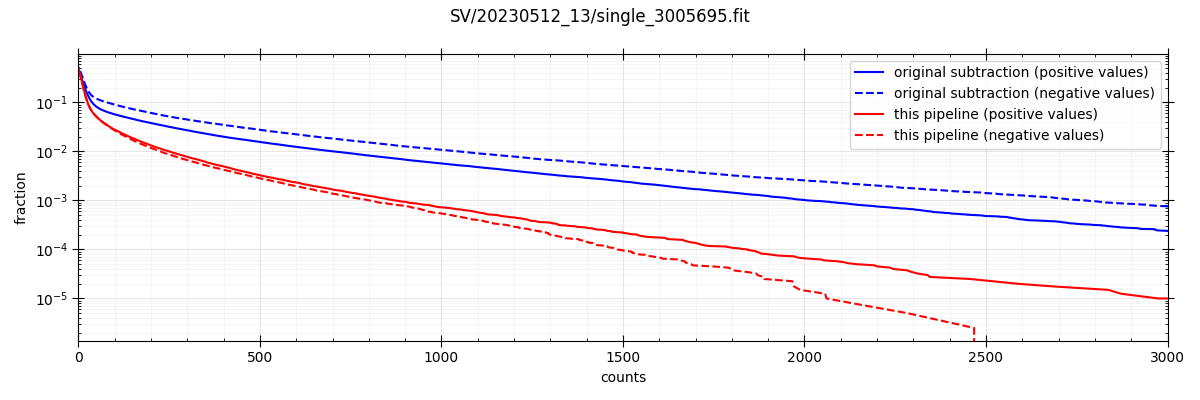

In [156]:
fig_name = 'sky_residuals'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 4))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(rss.filename)
for ax in axes.flat:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
    ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
    ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
    ax.grid(True, which='both')


def plot_fraction(x, ax, color, label):
    sorted_x = np.sort(x)
    sorted_x = sorted_x[np.isfinite(sorted_x)]
    n_negative = np.searchsorted(sorted_x, 0)
    n_positive = sorted_x.size - n_negative
    ax.plot(sorted_x[n_negative:], (n_positive - np.arange(n_positive))/sorted_x.size, c=color, ls='-', label=f'{label} (positive values)')
    ax.plot(-sorted_x[:n_negative], np.arange(n_negative)/sorted_x.size, c=color, ls='--', label=f'{label} (negative values)')

ax = axes[0, 0]
ax.set_ylabel(r'fraction')
ax.set_yscale('log')

plot_fraction((rss.counts[rss.sky_fibres] - rss.sky_counts[0]).flat, ax, 'b', 'original subtraction')
plot_fraction(sky_subtracted.flat, ax, 'r', 'this pipeline')
ax.legend()


ax = axes[-1, 0]
ax.set_xlabel(r'counts')
#ax.set_xscale('log')
#ax.set_xscale('symlog', linthresh=1000)
ax.set_xlim(0, 3000)


# --- OLD STUFF ---

## Wavelength calibration and fibre flat

In [32]:
median_sky = np.nanmedian(rss.counts[rss.sky_fibres], axis=0)

delta_lambda_grid = np.linspace(-5, 5, 201)

chi2 = np.empty((rss.n_sky_fibres, delta_lambda_grid.size))
norm_sky = np.sqrt(np.nanmean(median_sky*median_sky))
for i, fibre in enumerate(rss.sky_fibres[0]):
    fibre_counts = rss.counts[fibre]
    norm_model = np.sqrt(np.nanmean(model*model))
    for dl, delta_lambda in enumerate(delta_lambda_grid):
        model = np.interp(rss.wavelength, rss.wavelength-delta_lambda, fibre_counts)
        #norm = np.nanmean(model*median_sky) / norm_model / norm_sky
        norm = np.nanmedian(median_sky/model)
        model *= norm
        chi2[i, dl] = np.sqrt(np.nanmean(((median_sky - model) / (median_sky + model))**2))

/home/yago/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


NameError: name 'model' is not defined

In [ ]:
delta_lambda = np.empty(rss.n_sky_fibres)
interpolated_counts = np.empty((rss.n_sky_fibres, rss.wavelength.size))
for i, fibre in enumerate(rss.sky_fibres[0]):
    fibre_counts = rss.counts[fibre]
    delta_lambda[i] = delta_lambda_grid[np.argmin(chi2[i, :])]
    model = np.interp(rss.wavelength, rss.wavelength-delta_lambda[i], fibre_counts)
    interpolated_counts[i] =  model * np.nanmedian(median_sky/model)

interpolated_sky = np.nanmedian(interpolated_counts, axis=0)

In [ ]:
fig_name = 'wavelength_correction'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 5))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(rss.filename)
for ax in axes.flat:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
    ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
    ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
    ax.grid(True, which='both')


ax = axes[0, 0]
ax.set_ylabel(r'$\chi^2$')
ax.set_yscale('log')

for i, fibre in enumerate(rss.sky_fibres[0]):
    ax.plot(delta_lambda_grid, chi2[i], 'k-', alpha=.1)

ax = axes[0, 0]
ax.set_xlabel(r'wavelength correction [$\AA$]')

## Find peaks

In [ ]:
def find_peaks(data, min_distance=2):
    if min_distance < 2:
        print(f'WARNING: this routine is fool-proof ;^D')
        min_distance = 2
    peaks = []
    for i in range(min_distance, data.size-min_distance):
        if (data[i] > np.nanmax(data[i-min_distance:i])) and (data[i] > np.nanmax(data[i+1:i+min_distance])):
            peaks.append(i)
    return np.array(peaks)


median_sky = np.nanmedian(rss.counts[rss.sky_fibres], axis=0)
median_sky_peaks = find_peaks(median_sky, 20)

In [ ]:
def find_minima(data, peaks):
    minima = [0]
    for i in range(len(peaks)-1):
        minima.append(peaks[i]+1 + np.argmin(data[peaks[i]+1:peaks[i+1]]))
    minima.append(data.size-1)
    return np.array(minima)

median_sky_bins = find_minima(median_sky, median_sky_peaks)

In [ ]:
def find_momenta(wavelength, sky, bins):
    mean_counts = []
    mean_wave = []
    for i in range(len(bins)-1):
        bin_counts = np.array(sky[bins[i]:bins[i+1]])
        mean_counts.append(np.sqrt(np.nanmean(bin_counts**2)))
        bin_wave = np.array(wavelength[bins[i]:bins[i+1]])
        bin_counts -= bin_counts[0] + (bin_counts[-1] - bin_counts[0]) * (bin_wave - bin_wave[0]) / (bin_wave[-1] - bin_wave[0])
        mean_wave.append(np.nanmean(bin_wave*bin_counts**3) / np.nanmean(bin_counts**3))
        #print(i, bins[i], bins[i+1], bin_counts, bin_wave, mean_counts, mean_wave)
    return np.array(mean_counts), np.array(mean_wave)

median_sky_bin_counts, median_sky_bin_wave = find_momenta(rss.wavelength, median_sky, median_sky_bins)

In [ ]:
fibre_flat_counts = np.empty((rss.sky_fibres[0].size, median_sky_bins.size-1))
fibre_flat_wave = np.empty((rss.sky_fibres[0].size, median_sky_bins.size-1))
for i, counts in enumerate(rss.counts[rss.sky_fibres]):
    fibre_flat_counts[i], fibre_flat_wave[i] = find_momenta(rss.wavelength, counts, median_sky_bins)
fibre_flat_counts = np.array(fibre_flat_counts) / median_sky_bin_counts[np.newaxis, :]
fibre_flat = np.nanmedian(fibre_flat_counts, axis=1)
fibre_flat_wave = np.array(fibre_flat_wave)

In [ ]:
def smooth(x, delta):
    y = x.copy()
    y[1:] = np.where(delta[:-1] < delta[1:], y[:-1], y[1:])
    y[:-1] = np.where(delta[1:] < delta[:-1], y[1:], y[:-1])
    return y


fibre_flat_counts = smooth(fibre_flat_counts, np.abs(np.log(fibre_flat_counts)))
fibre_flat_wave = smooth(fibre_flat_wave, (fibre_flat_wave-median_sky_bin_wave)**2)

In [ ]:
interpolated_counts = np.empty_like(rss.counts[rss.sky_fibres])
for example_fibre in range(fibre_flat.size):
    example_counts = rss.counts[rss.sky_fibres[0][example_fibre]]
    good = np.isfinite(fibre_flat_counts[example_fibre])
    corrected_wave = rss.wavelength - np.interp(rss.wavelength, fibre_flat_wave[example_fibre][good], fibre_flat_wave[example_fibre][good]-median_sky_bin_wave[good])
    corrected_counts = example_counts / np.interp(rss.wavelength, fibre_flat_wave[example_fibre][good], fibre_flat_counts[example_fibre][good])
    good = np.isfinite(corrected_counts)
    interpolated_counts[example_fibre] = np.interp(rss.wavelength, corrected_wave[good], corrected_counts[good])
    #print(corrected_wave, corrected_counts, interpolated_counts[example_fibre])

In [ ]:
example_fibre = 0
example_counts = rss.counts[rss.sky_fibres[0][example_fibre]]

fig_name = 'wavelength_interpolation'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 8))
axes = fig.subplots(nrows=3, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(rss.filename)
for ax in axes.flat:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
    ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
    ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
    ax.grid(True, which='both')


ax = axes[0, 0]
ax.set_ylabel(r'median sky [counts]')
ax.set_yscale('log')

ax.plot(rss.wavelength, median_sky, 'k-', alpha=.5)
ax.plot(rss.wavelength[median_sky_peaks], median_sky[median_sky_peaks], 'k+')
for boundary in median_sky_bins:
    ax.axvline(rss.wavelength[boundary], c='k', ls=':', alpha=.3)
ax.plot(rss.wavelength[median_sky_bins], median_sky[median_sky_bins], 'g--', alpha=.5)
ax.plot(median_sky_bin_wave, median_sky_bin_counts, 'gx')

ax.plot(rss.wavelength, example_counts, 'r-', alpha=.3)
'''
ax.plot(rss.wavelength, example_counts/fibre_flat[example_fibre], 'r-', alpha=1)
ax.plot(fibre_flat_wave[example_fibre]+median_sky_bin_wave, fibre_flat_counts[example_fibre]*median_sky_bin_counts, 'ro', alpha=.2)
ax.plot(rss.wavelength-np.interp(rss.wavelength, fibre_wave[example_fibre], fibre_flat_wave[example_fibre]),
        example_counts/np.interp(rss.wavelength, fibre_wave[example_fibre], fibre_flat_counts[example_fibre]),
        'b-', alpha=.3)
'''
ax.plot(rss.wavelength, interpolated_counts[example_fibre], 'b-', alpha=.5)
ax.plot(rss.wavelength, np.nanmedian(interpolated_counts, axis=0), 'y-', alpha=1)

ax = axes[1, 0]
ax.set_ylabel(r'fibre flat residual')
#ax.set_yscale('log')
ax.set_ylim(.8, 1.2)

for i in range(rss.sky_fibres[0].size):
    ax.plot(fibre_flat_wave[i], fibre_flat_counts[i]/fibre_flat[i], 'g-', alpha=.1)
ax.plot(fibre_flat_wave[example_fibre], fibre_flat_counts[example_fibre]/fibre_flat[example_fibre], 'r-', alpha=1)


ax = axes[2, 0]
ax.set_ylabel(r'wavelength correction')
#ax.set_yscale('log')
ax.set_ylim(-5, 5)

for i in range(rss.sky_fibres[0].size):
    ax.plot(fibre_flat_wave[i], fibre_flat_wave[i]-median_sky_bin_wave, 'g-', alpha=.1)
ax.plot(fibre_flat_wave[example_fibre], fibre_flat_wave[example_fibre]-median_sky_bin_wave, 'r-', alpha=1)


ax = axes[-1, 0]
ax.set_xlabel(r'wavelength [$\AA$]')

## Wavelength interpolation

In [ ]:
median_sky = np.nanmedian(rss.counts[rss.sky_fibres], axis=0)
cumulative_median_sky = np.nancumsum(median_sky)
cumulative_sky = np.nancumsum(rss.counts[rss.sky_fibres], axis=1)

In [ ]:
'''
sky_fibre_flat = cumulative_sky/cumulative_median_sky[np.newaxis, :]
sky_fibre_flat = np.nanmean(sky_fibre_flat, axis=1)
cumulative_sky /= sky_fibre_flat[:, np.newaxis]
cumulative_median_sky = np.nanmedian(cumulative_sky, axis=0)
'''


def interpolate_vector(x, x_p, vector_p):
    p = np.searchsorted(x_p, x).clip(0, x_p.size-2)
    w = (x - x_p[p]) / (x_p[p+1] - x_p[p])
    y = w*vector_p[:, p+1] + (1-w)*vector_p[:, p]
    return y

def running_median(x, y, bin_size):
    bin_left = np.arange(0, x.size-bin_size, bin_size)
    bin_x = x[bin_left+bin_size//2]
    bin_y = np.zeros((y.shape[0], bin_x.size))
    for i, left in enumerate(bin_left):
        bin_y[:, i] = np.nanmedian(y[:, left:left+bin_size], axis=1)
    good = np.where(np.isfinite(bin_x))
    
    y = interpolate_vector(x, bin_x[good], bin_y[:, good[0]])
    '''
    bin_x = bin_x[good]
    bin_y = bin_y[:, good[0]]
    i = np.searchsorted(bin_x[good], x).clip(0, bin_x.size-2)
    w = (x - bin_x[i]) / (bin_x[i+1] - bin_x[i])
    y = w*bin_y[:, i+1] + (1-w)*bin_y[:, i]
    '''

    return y


running_flat = running_median(rss.wavelength, cumulative_sky/cumulative_median_sky, 100)
wavelength_correction = np.zeros_like(cumulative_sky)
for i, sky in enumerate(cumulative_sky/running_flat):
    wavelength_correction[i, :] = np.interp(sky, cumulative_median_sky, rss.wavelength) - rss.wavelength


In [ ]:
total_weight = np.sum(cumulative_median_sky)
wavelength_correction_avg = np.sum(wavelength_correction*cumulative_median_sky[np.newaxis, :], axis=1)/total_weight

In [ ]:
wavelength_correction_avg, np.mean(wavelength_correction_avg)

In [ ]:
fig_name = 'wavelength_interpolation'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 8))
axes = fig.subplots(nrows=2, ncols=2, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(rss.filename)
for ax in axes.flat:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
    ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
    ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
    ax.grid(True, which='both')


ax = axes[0, 0]
ax.set_ylabel(r'cumulative median sky [counts]')
ax.set_yscale('log')

ax.plot(rss.wavelength, cumulative_median_sky, 'k-')
for sky in cumulative_sky:
    ax.plot(rss.wavelength, sky, 'c-', alpha=.05)


ax = axes[1, 0]
ax.set_ylabel(r'scale factor')
#ax.set_yscale('log')
ax.set_ylim(.9, 1.1)

for sky in cumulative_sky:
    ax.plot(rss.wavelength, sky/cumulative_median_sky, 'c-', alpha=.05)


ax = axes[0, 1]
ax.plot(rss.wavelength, cumulative_median_sky, 'k-')
for sky in cumulative_sky/running_flat:
    ax.plot(rss.wavelength, sky, 'c-', alpha=.05)


ax = axes[1, 1]
for sky in cumulative_sky/running_flat:
    ax.plot(rss.wavelength, sky/cumulative_median_sky, 'c-', alpha=.05)

    
'''
ax = axes[2, 1]
for sky in wavelength_correction:
    ax.plot(rss.wavelength, sky, 'c-', alpha=.05)
'''


ax = axes[-1, 0]
ax.set_xlabel(r'wavelength [$\AA$]')
ax = axes[-1, 1]
ax.set_xlabel(r'wavelength [$\AA$]')


In [ ]:
fig_name = 'wavelength_correction'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 8))
axes = fig.subplots(nrows=2, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(rss.filename)
for ax in axes.flat:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
    ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
    ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
    ax.grid(True, which='both')


#wavelength_correction_std = np.std(wavelength_correction)
wavelength_correction_std = np.std(wavelength_correction_avg)

ax = axes[0, 0]
im = ax.imshow(wavelength_correction,
               extent=(rss.wavelength[0], rss.wavelength[-1], -.5, wavelength_correction.shape[0]-.5),
               interpolation='nearest', origin='lower',
               cmap='rainbow',
               vmin=-wavelength_correction_std, vmax=wavelength_correction_std,
              )
ax.set_aspect('auto')
ax.set_ylabel('fibre')
cb = fig.colorbar(im, ax=ax, orientation='vertical', shrink=.9)

ax = axes[1, 0]
ax.set_ylabel(r'wavelength correction')
#ax.set_yscale('log')
ax.set_ylim(-wavelength_correction_std, wavelength_correction_std)
cb = fig.colorbar(im, ax=ax, orientation='vertical', shrink=.9)

ax.plot(rss.wavelength, median_sky*wavelength_correction_std/np.nanstd(median_sky), 'k-', alpha=.5)
for sky in wavelength_correction:
    ax.plot(rss.wavelength, sky, 'c-', alpha=.05)


ax = axes[-1, 0]
ax.set_xlabel(r'wavelength [$\AA$]')
#ax.set_xlim(8400, 8500)

#for ax in axes.flat:
#    for line in rss.sky_lines['wavelength']:
#        ax.axvline(line, c='k', ls=':', alpha=.5)


In [ ]:
interpolated_counts = np.empty_like(rss.counts[rss.sky_fibres])
for i, corr in enumerate(wavelength_correction_avg):
    interpolated_counts[i, :] = np.interp(rss.wavelength+corr, rss.wavelength, rss.counts[i, :])


In [ ]:
fig_name = 'interpolated_counts_2D'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 8))
axes = fig.subplots(nrows=2, ncols=1, squeeze=False,
                    sharex='col', sharey=True,
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(rss.filename)

def show_data(x, data, ax, title, angle=0):
    #percentiles = np.array([0, 16, 50, 84, 100])
    percentiles = np.array([16, 50, 84])
    ticks = np.nanpercentile(data, percentiles)
    median = ticks[np.argmin(np.abs(percentiles-50))]
    std = np.std(data[data < median])
    im = ax.imshow(data,
                   extent=(x[0], x[-1], -.5, data.shape[0]-.5),
                   interpolation='nearest', origin='lower',
                   #cmap='nipy_spectral',
                   #cmap='terrain',
                   #cmap='gist_stern',
                   #cmap='ocean',
                   #cmap='gist_earth',
                   cmap='rainbow',
                   norm=colors.SymLogNorm(vmin=-1e4, vmax=1e4, linthresh=10),
                   #norm=colors.SymLogNorm(vmin=median-3*std, vmax=ticks[-1], linthresh=median+3*std),
                   #norm=colors.SymLogNorm(vmin=ticks[0], vmax=ticks[-1], linthresh=median),
                  )
    ax.set_aspect('auto')
    ax.set_ylabel('fibre')
    cb = fig.colorbar(im, ax=ax, orientation='vertical', shrink=.9)
    cb.ax.set_ylabel(title)
    cb.ax.set_yticks(ticks=ticks, labels=[f'{value:.3g} ({percent}%)' for value, percent in zip(ticks, percentiles)], rotation=angle)


show_data(rss.wavelength, rss.counts[rss.sky_fibres]-median_sky[np.newaxis, :], axes[0, 0], 'raw counts')
show_data(rss.wavelength, interpolated_counts-np.nanmedian(interpolated_counts, axis=0)[np.newaxis, :], axes[1, 0], 'wavelength corrected')

axes[-1, 0].set_xlabel(r'wavelength [$\AA$]')
#axes[-1, 0].set_xlim(8900, 9100)

'''
for ax in axes.flat:
    for i in range(median_sky_bins.size-1):
        #ax.plot(fibre_flat_wave[:, i], np.arange(rss.sky_fibres[0].size), 'k-')
        ax.plot(median_sky_bin_wave[i]+delta_lambda, np.arange(rss.n_sky_fibres), 'k-')
'''


# 2. Fibre flat

In [ ]:
fibre_flat = np.ones(rss.counts.shape[0])
old_residual = np.inf
new_residual = np.nanstd(rss.counts)
while new_residual < old_residual:
    
    # Estimate the sky:
    flat_corrected = rss.counts/fibre_flat[:, np.newaxis]
    p16, median_sky, p84 = np.nanpercentile(flat_corrected[sky_fibres], [16, 50, 84], axis=0)
    #p16, median_sky, p84 = np.nanpercentile(flat_corrected, [16, 50, 84], axis=0)
    median_sky_err = p84 - p16
    #median_sky = np.fmin(median_sky, np.nanmedian(flat_corrected[target_fibres], axis=0))

    # Find values witht highest sky fraction
    sky_fraction = median_sky/flat_corrected
    sky_fraction_threshold = np.nanpercentile(sky_fraction, 90, axis=1)
    sky_fraction_threshold = np.fmin(sky_fraction_threshold, 1/np.nanmax(sky_fraction, axis=1))
    sky_fraction = np.where(sky_fraction > sky_fraction_threshold[:, np.newaxis], sky_fraction, np.nan)
    fibre_flat = np.sqrt(fibre_flat/np.nanmedian(sky_fraction, axis=1))
    fibre_flat /= np.nanmedian(fibre_flat)

    flat_corrected = rss.counts/fibre_flat[:, np.newaxis]
    old_residual = new_residual
    new_residual = np.nanstd(np.nanmedian(flat_corrected, axis=0)/median_sky - 1)
    print(f'residual={new_residual:.4g}')


## 2D plot

In [ ]:
'''
fig_name = 'fibre_flat_2D'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(10, 8))
axes = fig.subplots(nrows=2, ncols=1, squeeze=False,
                    sharex='col', sharey=True,
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(rss.filename)


def show_data(data, ax, title, angle=0):
    percentiles = np.array([16, 50, 84])
    ticks = np.nanpercentile(data, percentiles)
    median = ticks[np.argmin(np.abs(percentiles-50))]
    std = np.std(data[data < median])
    extreme = max(ticks[-1], 1/ticks[0])
    im = ax.imshow(data,
                   #extent=(x[0], x[-1], -.5, data.shape[0]-.5),
                   interpolation='nearest', origin='lower',
                   cmap='rainbow',
                   #vmin=median-3*std, vmax=median+3*std,
                   #norm=colors.SymLogNorm(vmin=median-3*std, vmax=ticks[-1], linthresh=median+3*std),
                   #norm=colors.SymLogNorm(vmin=1/extreme, vmax=extreme, linthresh=1),
                   #norm=colors.SymLogNorm(vmin=.5, vmax=2, linthresh=1),
                   norm=colors.LogNorm(vmin=.5, vmax=2),
                  )
    ax.set_aspect('auto')
    ax.set_ylabel('fibre')
    cb = fig.colorbar(im, ax=ax, orientation='vertical', shrink=.9)
    cb.ax.set_ylabel(title)
    cb.ax.set_yticks(ticks=ticks, labels=[f'{value:.3g} ({percent}%)' for value, percent in zip(ticks, percentiles)], rotation=angle)


show_data(fibre_flat_map, axes[0, 0], 'fibre flat map')
show_data(fibre_flat_map/fibre_flat[:, np.newaxis], axes[1, 0], 'after correction')

axes[-1, 0].set_xlabel(r'sky-dominated pixels, in increasing wavelength order')
'''


## Values

In [ ]:
sorted_fibre_flat = np.sort(fibre_flat)
sorted_fibre_flat = sorted_fibre_flat[np.isfinite(sorted_fibre_flat)]
N_flat = sorted_fibre_flat.size
y_flat = np.arange(N_flat)
y_flat = (y_flat+1)*(N_flat-y_flat)/N_flat

In [ ]:
fig_name = 'fibre_flat_histogram'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(10, 8))
axes = fig.subplots(nrows=2, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(rss.filename)
for ax in axes.flat:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
    ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
    ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
    ax.grid(True, which='both')


ax = axes[0, 0]
ax.set_ylabel('fibre')

ax.plot(fibre_flat, np.arange(fibre_flat.size), 'k.')


ax = axes[1, 0]
ax.set_ylabel(r'$N_{below} \times N_{above} ~/~ N_{total}$')
ax.set_yscale('log')

ax.plot(sorted_fibre_flat, y_flat, 'k-')
median = sorted_fibre_flat[N_flat//2]
std = np.std(sorted_fibre_flat[:N_flat//2])
ax.axvspan(median-std, median+std, color='k', alpha=.1, label=f'{median:.3g} $\\pm$ {std:.3g}')
ax.legend(loc='upper left')


ax = axes[-1, 0]
ax.set_xlabel(r'fibre flat')
#ax.set_xscale('log')


## Wavelengths

In [ ]:
fig_name = 'fibre_flat_wavelengths'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 8))
axes = fig.subplots(nrows=4, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(rss.filename)
for ax in axes.flat:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
    ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
    ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
    ax.grid(True, which='both')

    
sky_fibres = np.where(rss.fibtable['TARGUSE'] == 'S')
target_fibres = np.where(rss.fibtable['TARGUSE'] == 'T')
flat_corrected = rss.counts/fibre_flat[:, np.newaxis]


def plot_band(counts, fibres, ax, color, label):
    p16, p50, p84 = np.nanpercentile(counts[fibres], [16, 50, 84], axis=0)
    ax.plot(rss.wavelength, p50, color=color, ls='-', alpha=.5)
    ax.fill_between(rss.wavelength, p16, p84, color=color, alpha=.2, label=label)


ax = axes[0, 0]
ax.set_ylabel('median counts')
ax.set_yscale('log')

plot_band(rss.counts, sky_fibres, ax, 'b', 'sky fibres')
plot_band(rss.counts, target_fibres, ax, 'g', 'target fibres')
ax.plot(rss.wavelength, np.nanmedian(rss.sky_counts, axis=0), 'k--', alpha=.5, label='original sky')
ax.plot(rss.wavelength, median_sky, 'k-', alpha=1, label='new sky')

#ax.plot(rss.wavelength[sky_dominated], median_sky[sky_dominated], 'k+', alpha=.2)
ax.legend()


ax = axes[1, 0]
ax.set_ylabel('flat-corrected median')
ax.set_yscale('log')

plot_band(flat_corrected, sky_fibres, ax, 'b', 'sky fibres')
plot_band(flat_corrected, target_fibres, ax, 'g', 'target fibres')
#ax.plot(rss.wavelength, np.nanmedian(flat_corrected[sky_fibres], axis=0), 'b:', alpha=.5, label='sky fibres')
#ax.plot(rss.wavelength, np.nanmedian(flat_corrected[target_fibres], axis=0), 'g-', alpha=.5, label='target fibres')
ax.plot(rss.wavelength, np.nanmedian(rss.sky_counts, axis=0), 'k--', alpha=.5, label='original sky')
ax.plot(rss.wavelength, median_sky, 'k-', alpha=1, label='new sky')


ax = axes[2, 0]
ax.set_ylabel('residual')
#ax.set_yscale('log')
ax.set_yscale('symlog', linthresh=10)

plot_band(flat_corrected-median_sky, sky_fibres, ax, 'b', 'sky fibres')
#plot_band(flat_corrected-median_sky, target_fibres, ax, 'g', 'target fibres')
plot_band(rss.counts-rss.sky_counts, sky_fibres, ax, 'k', 'original sky')
#ax.plot(rss.wavelength, np.nanmedian(rss.counts-rss.sky_counts, axis=0), 'k--', alpha=.5, label='original sky')
ax.plot(rss.wavelength, median_sky_err, 'r-', alpha=.25, label='sky error')

#ax.plot(rss.wavelength, np.nanmedian(flat_corrected[target_fibres], axis=0)/np.nanmedian(flat_corrected[sky_fibres], axis=0), 'k-', alpha=.5)

#ax.plot(rss.wavelength, median_sky/median_sky_err, 'r-', alpha=.5)
#ax.axhline(SN_threshold, c='k', ls=':', alpha=.5, label=f'S/N={SN_threshold:.4g}')
#ax.plot(rss.wavelength[sky_dominated], median_sky[sky_dominated]/median_sky_err[sky_dominated], 'k+', alpha=.2)
#ax.legend()


ax = axes[3, 0]
ax.set_ylabel('sky fraction')
ax.set_yscale('log')

plot_band(sky_fraction, sky_fibres, ax, 'b', 'sky fibres')
plot_band(sky_fraction, target_fibres, ax, 'g', 'sky fibres')
#p16, fibre_flat_residual, p84 = np.nanpercentile(fibre_flat_map, [16, 50, 84], axis=0)
#ax.plot(rss.wavelength[sky_dominated], fibre_flat_residual, 'r-', alpha=1, label=f'median={np.mean(fibre_flat_residual):.3g} $\\pm$ {np.std(fibre_flat_residual):.3g}')
#ax.fill_between(rss.wavelength[sky_dominated], p16, p84, color='k', alpha=.2, label=f'(perc. 84-16)/2={np.mean(p84-p16)/2:.3g} $\\pm$ {np.std((p84-p16)/2):.3g}')
ax.legend()


ax = axes[-1, 0]
ax.set_xlabel(r'wavelength [$\AA$]')
ax.set_xlim(8400, 8500)

for ax in axes.flat:
    for line in rss.sky_lines['wavelength']:
        ax.axvline(line, c='r', ls=':', alpha=.5)


## Sky subtraction

In [ ]:
fig_name = 'sky_subtraction'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 8))
axes = fig.subplots(nrows=4, ncols=1, squeeze=False,
                    sharex='col', sharey=True,
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(rss.filename)

def show_data(x, data, ax, title, angle=0):
    #percentiles = np.array([0, 16, 50, 84, 100])
    percentiles = np.array([16, 50, 84])
    ticks = np.nanpercentile(data, percentiles)
    #median = ticks[np.argmin(np.abs(percentiles-50))]
    #std = np.std(data[data < median])
    im = ax.imshow(data,
                   extent=(x[0], x[-1], -.5, data.shape[0]-.5),
                   interpolation='nearest', origin='lower',
                   #cmap='nipy_spectral',
                   #cmap='terrain',
                   #cmap='gist_stern',
                   #cmap='ocean',
                   cmap='gist_earth',
                   norm=colors.SymLogNorm(vmin=-20, vmax=3e4, linthresh=200),
                   #norm=colors.SymLogNorm(vmin=median-3*std, vmax=ticks[-1], linthresh=median+3*std),
                   #norm=colors.SymLogNorm(vmin=ticks[0], vmax=ticks[-1], linthresh=median),
                  )
    ax.set_aspect('auto')
    ax.set_ylabel('fibre')
    cb = fig.colorbar(im, ax=ax, orientation='vertical', shrink=.9)
    cb.ax.set_ylabel(title)
    cb.ax.set_yticks(ticks=ticks, labels=[f'{value:.3g} ({percent}%)' for value, percent in zip(ticks, percentiles)], rotation=angle)


show_data(rss.wavelength, rss.counts, axes[0, 0], 'raw counts')
show_data(rss.wavelength, sky_fraction, axes[1, 0], 'sky-dominated')
#show_data(rss.wavelength, flat_corrected, axes[1, 0], 'flat-corrected')
show_data(rss.wavelength, rss.counts-rss.sky_counts, axes[2, 0], 'original subtraction')
show_data(rss.wavelength, flat_corrected-median_sky, axes[3, 0], 'new subtraction')

ax = axes[-1, 0]
ax.set_xlabel(r'wavelength [$\AA$]')
ax.set_xlim(8400, 8500)

for ax in axes.flat:
    for line in rss.sky_lines['wavelength']:
        ax.axvline(line, c='r', ls=':', alpha=.5)


In [ ]:
8450*10/3e5

## Sky map

In [ ]:
fig_name = 'fibre_flat_skymap'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(10, 8))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    #subplot_kw={'projection':rss.wcs.celestial},
                    gridspec_kw={'hspace': 0, 'wspace': 0},
                   )
fig.set_tight_layout(True)
fig.suptitle(rss.filename)

ra = rss.fibtable['FIBRERA']
dec = rss.fibtable['FIBREDEC']

ax = axes[0, 0]
sc = ax.scatter(ra, dec, s=200, c=fibre_flat, cmap='rainbow', vmin=0.8, vmax=1.2)
cb = fig.colorbar(sc, ax=ax, orientation='vertical', shrink=.9)


# 3. Wavelength calibration

## Line Spread Function

In [ ]:
def fit_Gaussian(x, I):
    peak = np.nanmax(I)
    if np.isnan(peak):
        return np.nan, np.nan, np.nan, np.nan
    background = np.nanmin(I)
    mean_intensity = np.nanmean(I-background)
    mean_x = np.nanmean((I-background)*x)/mean_intensity
    sigma_x = np.sqrt(np.nanmean((I-background)*(x-mean_x)**2)/mean_intensity)

    x_min = x[np.nanargmin(I)]
    correction = np.exp(-.5*(x_min-mean_x)**2/sigma_x**2)
    line_flux = (peak-background)*np.sqrt(2*np.pi)*sigma_x/(1-correction)
    background = peak - line_flux/np.sqrt(2*np.pi)/sigma_x
    
    return background, line_flux, mean_x, sigma_x


In [ ]:
fig_name = 'sky_line_profiles'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(6, 4))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
for ax in axes.flat:
    ax.grid(True, alpha=.1)
fig.set_tight_layout(True)

ax = axes[0, 0]
ax.set_title('Sky line profile (LSF)')
ax.set_ylabel('normalised median counts')
#ax.set_yscale('log')
ax.set_xlabel(r'$\Delta v$ [km/s]')

def normalise(x):
    x -= np.median(x)
    norm = x[x.size//2]
    if norm > 0:
        x /= norm
    else:
        x *= np.nan
    return x

ax = axes[0, 0]
delta_v = np.linspace(-500, 500, 201)

median_skyline = np.zeros((rss.sky_lines['wavelength'].size, delta_v.size))
for i, line in enumerate(rss.sky_lines['wavelength']):
    l = (1+delta_v/3e5)*line
    sed = np.interp(l, rss.wavelength, median_sky)
    sed = normalise(sed)
    median_skyline[i] = sed
    ax.plot(delta_v, sed, 'c-', alpha=.05)

median_skyline = normalise(np.nanmedian(median_skyline, axis=0))
ax.plot(delta_v, median_skyline, 'k-')
ax.set_ylim(1.1*np.min(median_skyline), 1.1*np.max(median_skyline))

background = np.median(median_skyline)
line_left = np.max(delta_v[(delta_v < 0) & (median_skyline <= background)])
line_right = np.min(delta_v[(delta_v > 0) & (median_skyline <= background)])
ax.axvspan(line_left, line_right, color='k', alpha=.2)

narrow_profile = np.where((delta_v > line_left) & (delta_v < line_right))
delta_v = delta_v[narrow_profile]
median_skyline = median_skyline[narrow_profile]
background, line_flux, mean_v, sigma_v = fit_Gaussian(delta_v, median_skyline)

margin = (line_right-line_left)/4
x = np.linspace(line_left-margin, line_right+margin, delta_v.size*4)
ax.axvline(mean_v, c='b', ls=':', label=f'$\langle\Delta v\\rangle$ = {mean_v:.1f} km/s')
ax.plot(x, background+line_flux/np.sqrt(2*np.pi)/sigma_v*np.exp(-.5*((x-mean_v)/sigma_v)**2), 'b-', label=f'$\sigma_v$ = {sigma_v:.1f} km/s')
ax.axhline(background, c='b', ls=':', label=f'background = {background:.2f} counts')

ax.legend()

### Emission lines

In [ ]:
def total_line_emission(wavelength, skyline_wave, skyline_flux, skyline_scale):
    total_lines = np.zeros_like(wavelength)
    for (line, flux, scale) in zip(skyline_wave, skyline_flux, skyline_scale):
        lam = (1+delta_v/3e5)*line
        median_skyline_flux = np.nanmean(median_skyline)*(lam[-1]-lam[0])
        norm = flux*scale/median_skyline_flux
        if norm > 0:
            total_lines += norm * np.interp(wavelength, lam, median_skyline, left=0, right=0)
    return total_lines


# initial scale factor, assuming zero sky continuum

skyline_scale_red = np.ones_like(rss.sky_lines['wavelength'])
scale_factor = sky_red / total_line_emission(rss.wavelength, rss.sky_lines['wavelength'], skyline_flux_red, skyline_scale_red)
for i, line in enumerate(rss.sky_lines['wavelength']):
    lam = (1+delta_v/3e5)*line
    skyline_scale_red[i] = np.nanmin(np.interp(lam, rss.wavelength, scale_factor)).clip(min=0)

total_lines_red = total_line_emission(rss.wavelength, rss.sky_lines['wavelength'], skyline_flux_red, skyline_scale_red)


def find_continuum(wavelength, sky_spectrum, line_emission):
    sky_continuum = sky_spectrum - line_emission
    good_continuum = np.where(sky_continuum > line_emission)
    sky_continuum = np.interp(wavelength, wavelength[good_continuum], sky_continuum[good_continuum])
    sky_continuum = np.fmin(sky_continuum, sky_spectrum)

    bin_size = 20
    #bin_left = np.arange(0, wavelength.size-bin_size, bin_size)
    #bin_wavelength = wavelength[bin_left+bin_size//2]
    #bin_continuum = np.zeros_like(bin_wavelength)
    #for i, left in enumerate(bin_left):
    #    bin_continuum[i] = np.nanmin(sky_continuum[left:left+bin_size])
    #sky_continuum = np.interp(wavelength, bin_wavelength, bin_continuum)
    bin_size *= 2
    bin_left = np.arange(0, wavelength.size-bin_size, bin_size)
    bin_wavelength = wavelength[bin_left+bin_size//2]
    bin_continuum = np.zeros_like(bin_wavelength)
    for i, left in enumerate(bin_left):
        bin_continuum[i] += np.nanmean(sky_continuum[left:left+bin_size])
        #bin_continuum[i] += np.nanmedian(sky_continuum[left:left+bin_size])
        #bin_continuum[i] += np.nanmin(sky_continuum[left:left+bin_size])
        #bin_continuum[i] /= 3
    sky_continuum = np.interp(wavelength, bin_wavelength, bin_continuum)
    sky_continuum = np.fmin(sky_continuum, sky_spectrum)

    return sky_continuum


# Iteratively refine sky line+continuum estimates

old_residual = np.inf
new_residual = np.nanmax(sky_red)
while new_residual < .999*old_residual:
    old_residual = new_residual

    sky_continuum_red = find_continuum(rss.wavelength, sky_red, total_lines_red)

    epsilon = 1e-30*np.min(median_sky_err_red)
    rescale_factor = (sky_red - sky_continuum_red)/(total_lines_red + epsilon)
    #skyline_scale_red *= np.interp(rss.sky_lines['wavelength'], rss.wavelength, rescale_factor).clip(min=0.5, max=2.)
    #for i, line in enumerate(rss.sky_lines['wavelength']):
    #    lam = (1+delta_v/3e5)*line
    #    skyline_scale_red[i] *= np.nanmean(np.interp(lam, rss.wavelength, rescale_factor)).clip(min=0, max=2)
    for (line, flux, scale) in zip(rss.sky_lines['wavelength'], skyline_flux_red, skyline_scale_red):
        lam = (1+delta_v/3e5)*line
        median_skyline_flux = np.nanmean(median_skyline)*(lam[-1]-lam[0])
        norm = flux*scale/median_skyline_flux
        norm = 1/median_skyline_flux
        if norm > 0:
            factor = np.nanmean(np.interp(lam, rss.wavelength, rescale_factor)
                                        * norm * median_skyline
                                        / 1)*(lam[-1]-lam[0]) #np.interp(lam, rss.wavelength, total_lines_red)
            print(line, factor, flux*scale/factor, np.interp(line, rss.wavelength, rescale_factor))
            skyline_scale_red *= np.clip(factor, .5, 2.)
    total_lines_red = total_line_emission(rss.wavelength, rss.sky_lines['wavelength'], skyline_flux_red, skyline_scale_red)

    residual = (sky_red - (sky_continuum_red+total_lines_red)) / median_sky_err_red
    p16, p50, p84 = np.nanpercentile(residual, [16, 50, 84])
    new_residual = p84-p16
    print(np.nanmean(residual), np.nanstd(residual), [p16, p50, p84], p84-p16, new_residual/old_residual)

skyline_ew_red = skyline_flux_red*skyline_scale_red / np.interp(rss.sky_lines['wavelength'], rss.wavelength, sky_continuum_red)
strong_lines = np.where(skyline_ew_red > 3)

In [ ]:
def running_median(x, y, bin_size):
    bin_left = np.arange(0, x.size-bin_size, bin_size)
    bin_x = x[bin_left+bin_size//2]
    bin_y = np.zeros_like(bin_x)
    for i, left in enumerate(bin_left):
        bin_y[i] = np.nanmedian(y[left:left+bin_size])
        #bin_y[i] = np.nanmean(y[left:left+bin_size])

    return np.interp(x, bin_x, bin_y)

sky_scale_red = np.interp(rss.wavelength, rss.sky_lines['wavelength'][strong_lines], skyline_scale_red[strong_lines])
sky_scale_red_smooth = running_median(rss.wavelength, sky_scale_red, 100)

In [ ]:
fig_name = 'sky_continuum'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 4))
axes = fig.subplots(nrows=2, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
for ax in axes.flat:
    ax.grid(True, alpha=.1)
fig.set_tight_layout(True)


ax = axes[0, 0]
ax.set_ylabel('intensity I')
ax.set_yscale('log')

ax.plot(rss.wavelength, sky_red, color='r', alpha=.5)
ax.fill_between(rss.wavelength, sky_red-median_sky_err_red, sky_red+median_sky_err_red, color='r', alpha=.2)
for line in rss.sky_lines['wavelength']:
    ax.axvline(line, c='c', alpha=.05)
for line in rss.sky_lines['wavelength'][strong_lines]:
    ax.axvline(line, c='k', ls=':', alpha=.5)

ax.plot(rss.wavelength, sky_continuum_red, 'g-', alpha=.5)
ax.plot(rss.wavelength, sky_continuum_red+total_lines_red, 'k-', alpha=1)

ax = axes[1, 0]
ax.set_ylabel('scale factor')
ax.set_yscale('log')
ax.plot(rss.wavelength, 1e-16/sensitivity_function_red[0], 'r-', alpha=1)

#ax.plot(rss.wavelength, rescale_factor, 'g-', alpha=.25)
ax.plot(rss.sky_lines['wavelength'], np.interp(rss.sky_lines['wavelength'], rss.wavelength, rescale_factor), 'g.', alpha=.5)
#ax.set_ylim(.5, 2.5)
ax.plot(rss.sky_lines['wavelength'], skyline_scale_red, 'k+', alpha=.2)
ax.plot(rss.sky_lines['wavelength'][strong_lines], skyline_scale_red[strong_lines], 'kx:', alpha=.25)
#ax.plot(rss.wavelength, sky_scale_red, 'r-', alpha=1)
ax.plot(rss.wavelength, sky_scale_red_smooth, 'r--', alpha=1)
ax.set_ylim(.1, 1e4)

ax = axes[-1, 0]
ax.set_xlabel(r'wavelength [$\AA$]')
#ax.set_xlim(6100, 6400)
#ax.set_xlim(9300, 9400)
#ax.set_xlim(6250, 6350)

In [ ]:
np.nanpercentile(skyline_ew_red, [16, 50, 84])

In [ ]:
'''
skyline_scale_red = np.ones_like(rss.sky_lines['wavelength'])
skyline_continuum_red = np.ones_like(skyline_wave_red)
sky_continuum_red = np.zeros_like(sky_red)
def total_line_emission():
    total_lines_red = np.zeros_like(rss.wavelength)
    for (line, flux, scale) in zip(skyline_wave_red, skyline_flux_red, skyline_scale_red):
        lam = (1+delta_v/3e5)*line
        median_skyline_flux = np.mean(median_skyline)*(lam[-1]-lam[0])
        total_lines_red += np.interp(wavelength_red, lam, median_skyline, left=0, right=0)*flux*scale/median_skyline_flux
    return total_lines_red
'''


fig_name = 'sky_continuum_2'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 4))
axes = fig.subplots(nrows=2, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
for ax in axes.flat:
    ax.tick_params(axis='both', which='both', direction='in')
    ax.grid(True, alpha=.1)
fig.set_tight_layout(True)

ax = axes[0, 0]
ax.set_ylabel('intensity I')
ax.set_yscale('log')

ax.plot(wavelength_red, sky_red, color='r', alpha=.5)
ax.fill_between(wavelength_red, sky_red-median_sky_err_red, sky_red+median_sky_err_red, color='r', alpha=.2)
#ax.plot(wavelength_red, total_line_emission(), 'g:', alpha=.5)


scale_factor = (sky_red - sky_continuum_red)/total_line_emission()
skyline_scale_red *= np.interp(skyline_wave_red, wavelength_red, scale_factor).clip(min=0)
line_emission = total_line_emission().clip(min=0)
'''
sky_continuum_red = sky_red - line_emission
good_continuum = np.where(sky_continuum_red > line_emission)
sky_continuum_red = np.interp(wavelength_red, wavelength_red[good_continuum], sky_continuum_red[good_continuum])
sky_continuum_red = np.fmin(sky_continuum_red, sky_red)
for i, line in enumerate(skyline_wave_red):
    lam = (1+delta_v/3e5)*line
    skyline_continuum_red[i] = np.nanmin(np.interp(lam, wavelength_red, sky_continuum_red)).clip(min=0)

bin_size = 20
bin_left = np.arange(0, wavelength_red.size-bin_size, bin_size)
bin_wavelength = wavelength_red[bin_left+bin_size//2]
bin_continuum = np.zeros_like(bin_wavelength)
for i, left in enumerate(bin_left):
    bin_continuum[i] = np.nanmin(sky_continuum_red[left:left+bin_size])
sky_continuum_red = np.interp(wavelength_red, bin_wavelength, bin_continuum)
for i, left in enumerate(bin_left):
    bin_continuum[i] = np.nanmedian(sky_continuum_red[left:left+bin_size])
sky_continuum_red = np.interp(wavelength_red, bin_wavelength, bin_continuum)
'''

'''
continuum_weight = (sky_continuum_red/sky_red).clip(min=0, max=1)
integral_model = np.nancumsum(sky_continuum_red*continuum_weight)
integral_weight = np.nancumsum(continuum_weight)
smoothing_weight = (delta_v[-1] - delta_v[0])/3e5 * np.nanmean(wavelength_red[1:]/np.diff(wavelength_red))
w0 = (integral_weight - smoothing_weight).clip(min=integral_weight[0])
w1 = (integral_weight + smoothing_weight).clip(max=integral_weight[-1])
sky_continuum_red += (np.interp(w1, integral_weight, integral_model) - np.interp(w0, integral_weight, integral_model)) / (w1 - w0)
sky_continuum_red = np.fmin(sky_continuum_red/2, sky_red)
'''


ax.plot(wavelength_red, line_emission, 'k-', alpha=.1)
ax.plot(wavelength_red, sky_continuum_red, 'g-', alpha=.5)
ax.plot(wavelength_red, sky_continuum_red+line_emission, 'k-', alpha=1)
#ax.plot(skyline_wave_red, skyline_continuum_red, 'g+', alpha=1)
#ax.plot(bin_wavelength, bin_continuum, 'r--', alpha=.5)

ax = axes[1, 0]
ax.set_ylabel('scale factor')
ax.set_yscale('log')
ax.plot(wavelength_red, scale_factor, 'g-', alpha=.2)
ax.plot(skyline_wave_red, skyline_scale_red, 'k+', alpha=1)


ax = axes[-1, 0]
ax.set_xlabel(r'wavelength [$\AA$]')
ax.set_xlim(6100, 6400)

In [ ]:
np.min(skyline_flux_red), np.min(skyline_scale_red) > 0

In [ ]:
total_line_emission()

### Old fit

In [ ]:
new_model = np.zeros((skyline_wave.size, 4))
new_model[:, 1] = skyline_flux
new_model[:, 2] = skyline_wave
new_model[:, 3] = skyline_wave*sigma_v/3e5

new_line_weight_red = np.zeros_like(wavelength_red)
for i in range(skyline_wave.size):
    line_profile = new_model[i, 1]*np.exp(-.5*((wavelength_red-new_model[i, 2])/new_model[i, 3])**2)/np.sqrt(2*np.pi)/new_model[i, 3]
    new_line_weight_red += line_profile
new_line_weight_red += 1e-30*np.nanmean(new_line_weight_red[new_line_weight_red > 0])

new_background_model_red = np.zeros_like(wavelength_red)


In [ ]:
old_chi2 = np.inf
lam0, lam1 = np.searchsorted(wavelength_red, [skyline_wave[0], skyline_wave[-1]])
median_sky_err_red += 1e-30*np.mean(median_sky_err_red[median_sky_err_red > 0])
chi2 = np.std(sky_red[lam0:lam1]/median_sky_err_red[lam0:lam1])*1e30
print(chi2)

while chi2 < old_chi2:
    model = new_model.copy()
    total_line_weight_red = new_line_weight_red.copy()
    background_model_red = new_background_model_red.copy()
    old_chi2 = chi2
    new_line_weight_red = np.zeros_like(wavelength_red)
    new_background_model_red = np.zeros_like(wavelength_red)

    for i, line in enumerate(skyline_wave):
        lam = (1+delta_v/3e5)*line
        sky = np.interp(lam, wavelength_red, (sky_red-background_model_red)/total_line_weight_red)
        sky *= model[i, 1]*np.exp(-.5*((lam-model[i, 2])/model[i, 3])**2)/np.sqrt(2*np.pi)/model[i, 3]

        new_model[i] = fit_Gaussian(lam, sky)
        if np.isfinite(new_model[i, 1]):
            line_profile = new_model[i, 1]*np.exp(-.5*((wavelength_red-new_model[i, 2])/new_model[i, 3])**2)/np.sqrt(2*np.pi)/new_model[i, 3]

            new_line_weight_red += line_profile
            new_model[i, 0] += np.interp(new_model[i, 2], wavelength_red, background_model_red)
            #new_background_model_red += max(model[i, 0], 0) * line_profile
            new_background_model_red += new_model[i, 0] * line_profile
        else:
            #print(f'nan at {line:.1f} AA: {model[i]}')
            new_model[i] = np.zeros_like(model[i])
    new_line_weight_red += 1e-30*np.nanmean(new_line_weight_red[new_line_weight_red > 0])

    w = sky_red/(sky_red+new_line_weight_red)
    new_background_model_red = w*(sky_red-new_line_weight_red) + (1-w)*new_background_model_red/new_line_weight_red
    integral_model = np.cumsum(new_background_model_red*w)
    integral_w = np.cumsum(w)
    w_smooth = delta_v.size*2
    w0 = (integral_w - w_smooth).clip(min=integral_w[0])
    w1 = (integral_w + w_smooth).clip(max=integral_w[-1])
    new_background_model_red = (np.interp(w1, integral_w, integral_model) - np.interp(w0, integral_w, integral_model)) / (w1 - w0)

    chi2 = np.nanstd((sky_red[lam0:lam1] - new_background_model_red[lam0:lam1] - new_line_weight_red[lam0:lam1]) / median_sky_err_red[lam0:lam1])
    print(chi2)

chi2 = np.std((sky_red[lam0:lam1] - background_model_red[lam0:lam1] - total_line_weight_red[lam0:lam1]) / median_sky_err_red[lam0:lam1])
print(chi2)


In [ ]:
fig_name = 'sky_line_fit'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(8, 8))
axes = fig.subplots(nrows=4, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
for ax in axes.flat:
    ax.grid(True, alpha=.1)
fig.set_tight_layout(True)

ax = axes[0, 0]
ax.set_ylabel('counts')
ax.set_yscale('log')
ax.set_ylim(.1, 1e5)

sky_blue, median_sky_err_blue = find_continuum(wavelength_blue, raw_blue, ax, 'b')
sky_red, median_sky_err_red = find_continuum(wavelength_red, raw_red, ax, 'r')

for i, line in enumerate(skyline_wave):
    lam = (1+delta_v/3e5)*line
    ax.plot(lam,
            model[i, 0] + model[i, 1]*np.exp(-.5*((lam-model[i, 2])/model[i, 3])**2)/np.sqrt(2*np.pi)/model[i, 3],
            'k-', alpha=.1)

ax.plot(wavelength_red, background_model_red, 'g-', alpha=.5)
ax.plot(wavelength_red, background_model_red+total_line_weight_red, 'k--', alpha=.5)


ax = axes[1, 0]
ax.set_ylabel('counts / initial flux')
ax.set_yscale('log')

for i, line in enumerate(skyline_wave):
    ax.plot(line, model[i, 1]/skyline_flux[i], 'k+')

y = model[:, 1]/skyline_flux
p16, p50, p84 = np.nanpercentile(y, [16, 50, 84])
y_min = p50*(p16/p50)**3
y_max = p50*(p84/p50)**3
#good = (y > y_min) & (y < y_max)
ax.axhspan(p16, p84, label=f'{p50:.3g} +- ({p84:.3g}, {p16:.3g})', color='green', alpha=.2)
ax.axhline(y_max, color='green', alpha=.2, ls='--')
ax.axhline(y_min, color='green', alpha=.2, ls='--')
ax.legend()
#ax.set_ylim(.5*y_min, 1.5*y_max)


ax = axes[2, 0]
ax.set_ylabel(r'$\Delta\lambda$ [$\AA$]')
#ax.set_yscale('log')
#ax.set_ylim(-100, 100)

for i, line in enumerate(skyline_wave):
    ax.plot(line, model[i, 2]-line, 'k+')

y = model[:, 2]-skyline_wave
p16, p50, p84 = np.nanpercentile(y, [16, 50, 84])
y_min = p50 - 3*(p50-p16)
y_max = p50 + 3*(p84-p50)
#good &= (y > y_min) & (y < y_max)
ax.axhspan(p16, p84, label=f'{p50:.3g} +- ({p84:.3g}, {p16:.3g})', color='green', alpha=.2)
ax.axhline(y_max, color='green', alpha=.2, ls='--')
ax.axhline(y_min, color='green', alpha=.2, ls='--')
ax.legend()
margin = .5*(y_max-y_min)
#ax.set_ylim(y_min-margin, y_max+margin)
ax.set_ylim(-5, 5)
ax.plot(wavelength_red, (sky_red - background_model_red - total_line_weight_red) / median_sky_err_red, 'k--')


ax = axes[3, 0]
ax.set_ylabel(r'$\sigma_\lambda$ [$\AA$]')
#ax.set_yscale('log')
#ax.set_ylim(-100, 100)

for i, line in enumerate(skyline_wave):
    ax.plot(line, model[i, 3], 'k+')

y = model[:, 3]
p16, p50, p84 = np.nanpercentile(y, [16, 50, 84])
y_min = p50 - 3*(p50-p16)
y_max = p50 + 3*(p84-p50)
#good &= (y > y_min) & (y < y_max)
ax.axhspan(p16, p84, label=f'{p50:.3g} +- ({p84:.3g}, {p16:.3g})', color='green', alpha=.2)
ax.axhline(y_max, color='green', alpha=.2, ls='--')
ax.axhline(y_min, color='green', alpha=.2, ls='--')
ax.legend()
margin = .5*(y_max-y_min)
ax.set_ylim(y_min-margin, y_max+margin)

ax = axes[-1, 0]
ax.set_xlabel(r'wavelength [$\AA$]')
ax.set_xlim(skyline_wave[0], skyline_wave[-1])
#ax.set_xlim(6200, 6400)
#ax.set_xlim(6500, 6600)
#ax.set_xlim(5800, 5900)


In [ ]:
delta_v.size

In [ ]:
mean_counts_red = np.nanmean(hdu_red[1].data, axis=0)  # same as hdu[6]
mean_sky_map_red = np.nanmean(hdu_red[3].data-hdu_red[1].data, axis=0)

mask_bright = mean_counts_red > mean_sky_map_red
mask_faint = (mean_counts_red > 0) & (mean_counts_red <= mean_sky_map_red)
mask_all = mean_counts_red > 0

In [ ]:
plt.close('counts')
fig = plt.figure('counts', figsize=(6, 4))
ax = fig.subplots(nrows=1, ncols=2, squeeze=False,
                  sharex=True, sharey=True,
                  gridspec_kw={'hspace': 0, 'wspace': 0}
                 )
fig.set_tight_layout(True)


def show_data(data, ax, title):
    p0, p10, p50, p90, p100 = np.nanpercentile(data[data>0], [0, 10, 50, 90, 100])
    im = ax.imshow(data,
                   interpolation='nearest', origin='lower',
                   cmap='nipy_spectral',
                   norm=colors.SymLogNorm(vmin=p0, vmax=p100, linthresh=p50-p0),
                  )
    ax.contour(mask_faint, levels=[0.5], colors=['w'])
    cb = fig.colorbar(im, ax=ax, orientation='horizontal')
    cb.ax.set_title(title)
    cb.ax.set_xticks(ticks=[p10, p50, p90], labels=[f'{p10:.3g}', f'{p50:.3g}', f'{p90:.3g}'], rotation=30)

show_data(mean_counts_red, ax[0, 0], 'Mean counts')
show_data(mean_sky_map_red, ax[0, 1], 'Mean sky')

plt.show()

### broadband colors:

In [ ]:
class Filter(object):
    
    def __init__(self, filename, col_wavelength=0, col_response=1):
        self.wavelength, self.response = np.loadtxt(filename, usecols=(col_wavelength, col_response), unpack=True)        
        #self.norm_AB =  np.trapz(3631/3.34e4 * self.response/self.wavelength, self.wavelength)
        self.pivot_wavelength =  np.sqrt(
            np.trapz(self.response, self.wavelength) / np.trapz(self.response/self.wavelength**2, self.wavelength))
        
    def m_AB(self, wavelength, F_lambda):
        """F_lambda in erg/s/cm^2/AA"""
        response = np.interp(wavelength, self.wavelength, self.response)
        return -2.5*np.log10(
            np.trapz(wavelength*F_lambda*response, wavelength) / np.trapz(3631/3.34e4 * response/wavelength, wavelength))

    def m_AB_cube(self, wavelength, F_lambda_cube):
        """F_lambda in erg/s/cm^2/AA"""
        response = np.interp(wavelength, self.wavelength, self.response)
        return -2.5*np.log10(
            np.trapz(F_lambda_cube*(wavelength*response)[:, np.newaxis, np.newaxis], wavelength, axis=0) / np.trapz(3631/3.34e4 * response/wavelength, wavelength))

g_filter = Filter('sdss-filters/g.dat', 0, 2)
r_filter = Filter('sdss-filters/r.dat', 0, 2)
i_filter = Filter('sdss-filters/i.dat', 0, 2)
z_filter = Filter('sdss-filters/z.dat', 0, 2)

### average SED within each region and broadband maps:

In [ ]:
datacube = (hdu_red[3].data - hdu_red[1].data) * sensitivity_function_red[:, np.newaxis, np.newaxis]
sky_red = np.sum(datacube*mask_all[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_all)
datacube = (hdu_blue[3].data - hdu_blue[1].data) * sensitivity_function_blue[:, np.newaxis, np.newaxis]
sky_blue = np.sum(datacube*mask_all[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_all)


In [ ]:
LIFU_FIBRE_RADIUS = 1.305  # arcsec (2.6 arcsec diameter)
LIFU_FIBRE_AREA = np.pi*LIFU_FIBRE_RADIUS**2
datacube = hdu_red[1].data * sensitivity_function_red[:, np.newaxis, np.newaxis] / LIFU_FIBRE_AREA
SED_bright_red = np.sum(datacube*mask_bright[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_bright)
SED_faint_red = np.sum(datacube*mask_faint[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_faint)
r_map = r_filter.m_AB_cube(wavelength_red, datacube)
i_map = i_filter.m_AB_cube(wavelength_red, datacube)
z_map = z_filter.m_AB_cube(wavelength_red, datacube)

In [ ]:
datacube = hdu_blue[1].data * sensitivity_function_blue[:, np.newaxis, np.newaxis] / LIFU_FIBRE_AREA
SED_bright_blue = np.sum(datacube*mask_bright[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_bright)
SED_faint_blue = np.sum(datacube*mask_faint[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_faint)
g_map = g_filter.m_AB_cube(wavelength_blue, datacube)


In [ ]:
def show_data(data, ax, title, cmap, vmin, vmax, projection):
    im = ax.imshow(data,
                   interpolation='nearest', origin='lower',
                   cmap=cmap, vmin=vmin, vmax=vmax,
                  )
    ax.contour(mask_bright, levels=[0.5], colors=['w'])
    cb = fig.colorbar(im, ax=ax, orientation='horizontal')
    cb.ax.set_title(title)
    #cb.ax.set_xticks(ticks=[p10, p50, p90], labels=[f'{p10:.3g}', f'{p50:.3g}', f'{p90:.3g}'], rotation=30)


In [ ]:
fig_name = 'broadband_SED'
plt.close(fig_name)
nrows = 2
ncols = 4.1
margin1 = .1
margin2 = .05
L = 1-margin2-margin1
dx = L/ncols
dy = L/nrows
panel_size = 3
fig = plt.figure(fig_name, figsize=(panel_size*ncols, panel_size*nrows))

def init_axis(x, y, wcs):
    ax = fig.add_axes([margin1+x*dx, margin1+y*dy, dx, dy], projection=wcs,
                      sharex=ax0, sharey=ax0
                     )
    ax. grid(True, alpha=.5)
    if(y > 0):
        ax.coords[0].set_auto_axislabel(False)
        ax.coords[1].set_auto_axislabel(False)
        ax.coords[0].set_ticklabel_visible(False)
    if(x > 0):
        ax.coords[0].set_auto_axislabel(False)
        ax.coords[1].set_auto_axislabel(False)
        ax.coords[1].set_ticklabel_visible(False)
    return ax


y = 1
mag_min = 17
mag_max = 25

ax0 = fig.add_axes([margin1, margin1+y*dy, dx, dy], projection=wcs_blue.celestial)
ax = ax0
ax. grid(True, alpha=.5)
im = ax.imshow(g_map,
               interpolation='nearest', origin='lower',
               cmap='nipy_spectral_r', vmin=mag_min, vmax=mag_max,
              )
ax = init_axis(1, y, wcs_red.celestial)
im = ax.imshow(r_map,
               interpolation='nearest', origin='lower',
               cmap='nipy_spectral_r', vmin=mag_min, vmax=mag_max,
              )
ax = init_axis(2, y, wcs_red.celestial)
im = ax.imshow(i_map,
               interpolation='nearest', origin='lower',
               cmap='nipy_spectral_r', vmin=mag_min, vmax=mag_max,
              )
ax = init_axis(3, y, wcs_red.celestial)
im = ax.imshow(z_map,
               interpolation='nearest', origin='lower',
               cmap='nipy_spectral_r', vmin=mag_min, vmax=mag_max,
              )
ax = fig.add_axes([margin1+4*dx, margin1+y*dy, .1*dx, dy])
cb = fig.colorbar(im, cax=ax, orientation='vertical')
ax.set_ylim(mag_max, mag_min)

y = 0
color_min = -.1
color_max = 1.1

ax = init_axis(0, y, wcs_red.celestial)
im = ax.imshow(g_map-r_map,
               interpolation='nearest', origin='lower',
               cmap='rainbow', vmin=color_min, vmax=color_max,
              )
ax = init_axis(1, y, wcs_red.celestial)
im = ax.imshow(r_map-i_map,
               interpolation='nearest', origin='lower',
               cmap='rainbow', vmin=color_min, vmax=color_max,
              )
ax = init_axis(2, y, wcs_red.celestial)
im = ax.imshow(i_map-z_map,
               interpolation='nearest', origin='lower',
               cmap='rainbow', vmin=color_min, vmax=color_max,
              )
ax = init_axis(3, y, wcs_red.celestial)
im = ax.imshow(r_map-z_map,
               interpolation='nearest', origin='lower',
               cmap='rainbow', vmin=color_min, vmax=color_max,
              )
ax = fig.add_axes([margin1+4*dx, margin1+y*dy, .1*dx, dy])
cb = fig.colorbar(im, cax=ax, orientation='vertical')


plt.tight_layout()

In [ ]:
fig_name = 'broadband_PS1'
plt.close(fig_name)
nrows = 2
ncols = 4.1
margin1 = .1
margin2 = .05
L = 1-margin2-margin1
dx = L/ncols
dy = L/nrows
panel_size = 3
fig = plt.figure(fig_name, figsize=(panel_size*ncols, panel_size*nrows))

xmin, xmax = ax0.get_xlim()
ymin, ymax = ax0.get_ylim()
print(xmin, xmax, ymin, ymax)
bottom_left = wcs_red.celestial.pixel_to_world(xmin, ymin)
top_right = wcs_red.celestial.pixel_to_world(xmax, ymax)
print(bottom_left.ra, top_right.ra, bottom_left.dec, top_right.dec)
xmin, ymin = wcs_r.world_to_pixel_values(bottom_left.ra, bottom_left.dec)
xmax, ymax = wcs_r.world_to_pixel_values(top_right.ra, top_right.dec)
print(xmin, xmax, ymin, ymax)

def init_axis(x, y, wcs):
    ax = fig.add_axes([margin1+x*dx, margin1+y*dy, dx, dy], projection=wcs,
                      sharex=ax1, sharey=ax1
                     )
    ax. grid(True, alpha=.5)
    if(y > 0):
        ax.coords[0].set_auto_axislabel(False)
        ax.coords[1].set_auto_axislabel(False)
        ax.coords[0].set_ticklabel_visible(False)
    if(x > 0):
        ax.coords[0].set_auto_axislabel(False)
        ax.coords[1].set_auto_axislabel(False)
        ax.coords[1].set_ticklabel_visible(False)
    #ax.set_xlabel(' ')
    #ax.set_ylabel(' ')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    return ax


y = 1
#mag_min = 15.5
#mag_max = 25.5

ax1 = fig.add_axes([margin1, margin1+y*dy, dx, dy], projection=wcs_g)
ax = ax1
ax. grid(True, alpha=.5)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
im = ax.imshow(PS1_g,
               interpolation='nearest', origin='lower',
               cmap='nipy_spectral_r', vmin=mag_min, vmax=mag_max,
              )
ax = init_axis(1, y, wcs_r)
im = ax.imshow(PS1_r,
               interpolation='nearest', origin='lower',
               cmap='nipy_spectral_r', vmin=mag_min, vmax=mag_max,
              )
ax = init_axis(2, y, wcs_i)
im = ax.imshow(PS1_i,
               interpolation='nearest', origin='lower',
               cmap='nipy_spectral_r', vmin=mag_min, vmax=mag_max,
              )
ax = init_axis(3, y, wcs_z)
im = ax.imshow(PS1_z,
               interpolation='nearest', origin='lower',
               cmap='nipy_spectral_r', vmin=mag_min, vmax=mag_max,
              )
ax = fig.add_axes([margin1+4*dx, margin1+y*dy, .1*dx, dy])
cb = fig.colorbar(im, cax=ax, orientation='vertical')


y = 0
#color_min = .1
#color_max = .9

ax = init_axis(0, y, wcs_r)
im = ax.imshow(PS1_g-PS1_r,
               interpolation='nearest', origin='lower',
               cmap='rainbow', vmin=color_min, vmax=color_max,
              )
ax = init_axis(1, y, wcs_r)
im = ax.imshow(PS1_r-PS1_i,
               interpolation='nearest', origin='lower',
               cmap='rainbow', vmin=color_min, vmax=color_max,
              )
ax = init_axis(2, y, wcs_r)
im = ax.imshow(PS1_i-PS1_z,
               interpolation='nearest', origin='lower',
               cmap='rainbow', vmin=color_min, vmax=color_max,
              )
ax = init_axis(3, y, wcs_r)
im = ax.imshow(PS1_r-PS1_z,
               interpolation='nearest', origin='lower',
               cmap='rainbow', vmin=color_min, vmax=color_max,
              )
ax = fig.add_axes([margin1+4*dx, margin1+y*dy, .1*dx, dy])
cb = fig.colorbar(im, cax=ax, orientation='vertical')


plt.tight_layout()

## 3. Spectrophotometric calibration:
### Compute correction:

In [ ]:

def find_continuum(x, y, n=1):
    peaks = np.where(y > 0); xx, yy = x[peaks], y[peaks]
    peaks = np.where((yy[1:-1] <= yy[:-2]) & (yy[1:-1] <= yy[2:])); xx, yy = xx[1:-1][peaks], yy[1:-1][peaks]
    xx = xx[1:-1]; yy = np.median(np.vstack((yy[:-2], yy[1:-1], yy[2:])), axis=0)
    while n > 1:
        peaks = np.where((yy[1:-1] <= yy[:-2]) & (yy[1:-1] <= yy[2:])); xx, yy = xx[1:-1][peaks], yy[1:-1][peaks]
        xx = xx[1:-1]; yy = np.median(np.vstack((yy[:-2], yy[1:-1], yy[2:])), axis=0)
        n -=1
    return xx, yy

wavelength_blue_continuum, sky_blue_continuum = find_continuum(wavelength_blue, sky_blue, 3);
wavelength_red_continuum, sky_red_continuum = find_continuum(wavelength_red, sky_red, 3);
wavelength_SkyCalc_continuum, intensity_SkyCalc_continuum = find_continuum(wavelength_SkyCalc, intensity_SkyCalc, 2);
correction_blue = intensity_SkyCalc_continuum / np.interp(wavelength_SkyCalc_continuum, wavelength_blue_continuum, sky_blue_continuum)
correction_blue = np.interp(wavelength_blue, wavelength_SkyCalc_continuum, correction_blue)
correction_blue /= np.median(correction_blue)
correction_red = intensity_SkyCalc_continuum / np.interp(wavelength_SkyCalc_continuum, wavelength_red_continuum, sky_red_continuum)
correction_red = np.interp(wavelength_red, wavelength_SkyCalc_continuum, correction_red)
correction_red /= np.median(correction_red)


In [ ]:
g_bright = g_filter.m_AB(wavelength_blue, SED_bright_blue)
r_bright = r_filter.m_AB(wavelength_red, SED_bright_red)
i_bright = i_filter.m_AB(wavelength_red, SED_bright_red)
z_bright = z_filter.m_AB(wavelength_red, SED_bright_red)
g_faint = g_filter.m_AB(wavelength_blue, SED_faint_blue)
r_faint = r_filter.m_AB(wavelength_red, SED_faint_red)
i_faint = i_filter.m_AB(wavelength_red, SED_faint_red)
z_faint = z_filter.m_AB(wavelength_red, SED_faint_red)
g_sky = g_filter.m_AB(wavelength_blue, sky_blue)
r_sky = r_filter.m_AB(wavelength_red, sky_red)
i_sky = i_filter.m_AB(wavelength_red, sky_red)
z_sky = z_filter.m_AB(wavelength_red, sky_red)


In [ ]:
lines = {}
lines['OII_3726'] = [3726.032, 3717.0, 3737.0]
lines['OII_3729'] = [3728.815, 3717.0, 3737.0]
lines['NeIII_3869'] = [3869.060, 3859.0, 3879.0]
lines['H_delta'] = [4101.734, 4092.0, 4111.0]
lines['H_gamma'] = [4340.464, 4330.0, 4350.0]
lines['OIII_4363'] = [4363.210, 4350.0, 4378.0]
lines['H_beta'] = [4861.325, 4851.0, 4871.0]
lines['OIII_4959'] = [4958.911, 4949.0, 4969.0]
lines['OIII_5007'] = [5006.843, 4997.0, 5017.0]
lines['HeI_5876'] = [5875.67, 5866.0, 5886.0]
lines['OI_6300'] = [6300.304, 6290.0, 6310.0]
lines['NII_6548'] = [6548.040, 6533.0, 6553.0]
lines['H_alpha'] = [6562.800, 6550., 6575., 6470., 6530., 6600., 6660.]
lines['NII_6584'] = [6583.460, 6573.0, 6593.0]
lines['SII_6717'] = [6716.440, 6704.0, 6724.0]
lines['SII_6731'] = [6730.810, 6724.0, 6744.0]
lines['CaT-a'] = [8500.36, np.nan, np.nan]
lines['CaT-b'] = [8544.44, np.nan, np.nan]
lines['CaT-c'] = [8664.52, np.nan, np.nan]

# NGC 7318
redshift_a = 6630/3e5
redshift_b = 5774/3e5

#wavelength_bins = np.array(lines['H_alpha'])
#indices_Ha_a = np.searchsorted(wavelength, wavelength_bins*(1+redshift_a))
#indices_Ha_b = np.searchsorted(wavelength, wavelength_bins*(1+redshift_b))


In [ ]:
plt.close('spectra')
fig = plt.figure('spectra', figsize=(8, 8))
ax = fig.subplots(nrows=3, ncols=1, squeeze=False,
                  sharex=True, sharey=False,
                  gridspec_kw={'hspace': 0, 'wspace': 0}
                 )
fig.set_tight_layout(True)

ax[0, 0].set_title(r'Collapsed spectra')
#ax[0, 0].set_ylabel(r'Mean intensity [erg/s/cm$^2/\AA$/... pixel?]')

ax[0, 0].plot(wavelength_red, SED_bright_red, 'k-', label='bright')
ax[0, 0].plot(wavelength_blue, SED_bright_blue, 'k-')

ax[0, 0].plot(wavelength_red, SED_faint_red, 'r-', label='faint')
ax[0, 0].plot(wavelength_blue, SED_faint_blue, 'r-')

ax[0, 0].plot(wavelength_red, sky_red, 'k-', alpha=.2, label='sky')
ax[0, 0].plot(wavelength_blue, sky_blue, 'k-', alpha=.2)


ax[0, 0].fill_between(g_filter.wavelength, 1e-18, g_filter.response*1e-15, color='blue', alpha=.2, label='SDSS g')
ax[0, 0].fill_between(r_filter.wavelength, 1e-18, r_filter.response*1e-15, color='green', alpha=.2, label='SDSS r')
ax[0, 0].fill_between(i_filter.wavelength, 1e-18, i_filter.response*1e-15, color='yellow', alpha=.2, label='SDSS i')
ax[0, 0].fill_between(z_filter.wavelength, 1e-18, z_filter.response*1e-15, color='red', alpha=.2, label='SDSS z')

ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_bright)/g_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_bright)/g_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_bright)/r_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_bright)/r_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_bright)/i_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_bright)/i_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_bright)/z_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_bright)/z_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_faint)/g_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_faint)/g_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_faint)/r_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_faint)/r_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_faint)/i_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_faint)/i_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_faint)/z_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_faint)/z_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].legend()

for line in lines:
    ax[0, 0].axvline(lines[line][0]*(1+redshift_a), c='r', alpha=.6, ls='--')
    ax[0, 0].axvline(lines[line][0]*(1+redshift_b), c='b', alpha=.6, ls=':')
    ymin, ymax = ax[0, 0].get_ylim()
    ax[0, 0].annotate(line, xy=(lines[line][0]*(1+redshift_a), .05), xycoords=('data', 'axes fraction'), rotation=90)
    #print(lines[line][0]*(1+redshift_a), ymin, line)


ax[0, -1].set_yscale('log')
ax[0, -1].set_ylim(3e-18, 3e-15)


#ax[1, 0].set_ylabel(r'Sky intensity [erg/s/cm$^2/\AA$/arcsec$^2$]')
ax[1, 0].set_ylabel(r'Intensity [erg/s/cm$^2/\AA$/arcsec$^2$]')

ax[1, 0].plot(wavelength_SkyCalc, intensity_SkyCalc, 'c-', label='ESO SkyCalc')
ax[1, 0].plot(wavelength_red, sky_red, 'k-', alpha=.2, label='sky')
ax[1, 0].plot(wavelength_blue, sky_blue, 'k-', alpha=.2)

ax[1, 0].plot(wavelength_blue_continuum, sky_blue_continuum, 'b.-')
ax[1, 0].plot(wavelength_red_continuum, sky_red_continuum, 'r.-')
ax[1, 0].plot(wavelength_SkyCalc_continuum, intensity_SkyCalc_continuum, 'k.-')

ax[1, 0].legend()
ax[1, -1].set_yscale('log')
ax[1, -1].set_ylim(3e-18, 3e-15)


ax[2, 0].set_ylabel(r'Correction factor')

ax[2, 0].plot(wavelength_blue, correction_blue, 'b-')
ax[2, 0].plot(wavelength_red, correction_red, 'r-')


ax[-1, 0].set_xlabel(r'wavelength [$\AA$]')
ax[-1, -1].set_xlim(3550, 9550)



ax[0, 0].grid()
plt.show()

In [ ]:
plt.close('corrected')
fig = plt.figure('corrected', figsize=(8, 8))
ax = fig.subplots(nrows=3, ncols=1, squeeze=False,
                  sharex=True, sharey=False,
                  gridspec_kw={'hspace': 0, 'wspace': 0}
                 )
fig.set_tight_layout(True)

ax[0, 0].set_title(r'Collapsed spectra')
#ax[0, 0].set_ylabel(r'Mean intensity [erg/s/cm$^2/\AA$/... pixel?]')

ax[0, 0].plot(wavelength_red, SED_bright_red*correction_red, 'k-', label='bright')
ax[0, 0].plot(wavelength_blue, SED_bright_blue*correction_blue, 'k-')

ax[0, 0].plot(wavelength_red, SED_faint_red*correction_red, 'r-', label='faint')
ax[0, 0].plot(wavelength_blue, SED_faint_blue*correction_blue, 'r-')

ax[0, 0].plot(wavelength_red, sky_red*correction_red, 'k-', alpha=.2, label='sky')
ax[0, 0].plot(wavelength_blue, sky_blue*correction_blue, 'k-', alpha=.2)


ax[0, 0].fill_between(g_filter.wavelength, 1e-18, g_filter.response*1e-15, color='blue', alpha=.2, label='SDSS g')
ax[0, 0].fill_between(r_filter.wavelength, 1e-18, r_filter.response*1e-15, color='green', alpha=.2, label='SDSS r')
ax[0, 0].fill_between(i_filter.wavelength, 1e-18, i_filter.response*1e-15, color='yellow', alpha=.2, label='SDSS i')
ax[0, 0].fill_between(z_filter.wavelength, 1e-18, z_filter.response*1e-15, color='red', alpha=.2, label='SDSS z')

ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_bright)/g_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_bright)/g_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_bright)/r_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_bright)/r_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_bright)/i_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_bright)/i_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_bright)/z_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_bright)/z_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_faint)/g_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_faint)/g_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_faint)/r_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_faint)/r_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_faint)/i_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_faint)/i_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_faint)/z_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_faint)/z_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].legend()

for line in lines:
    ax[0, 0].axvline(lines[line][0]*(1+redshift_a), c='r', alpha=.6, ls='--')
    ax[0, 0].axvline(lines[line][0]*(1+redshift_b), c='b', alpha=.6, ls=':')
    ymin, ymax = ax[0, 0].get_ylim()
    ax[0, 0].annotate(line, xy=(lines[line][0]*(1+redshift_a), .05), xycoords=('data', 'axes fraction'), rotation=90)
    #print(lines[line][0]*(1+redshift_a), ymin, line)


ax[0, -1].set_yscale('log')
ax[0, -1].set_ylim(3e-18, 3e-15)


#ax[1, 0].set_ylabel(r'Sky intensity [erg/s/cm$^2/\AA$/arcsec$^2$]')
ax[1, 0].set_ylabel(r'Intensity [erg/s/cm$^2/\AA$/arcsec$^2$]')

ax[1, 0].plot(wavelength_SkyCalc, 1.8*intensity_SkyCalc, 'c-', alpha=.2, label='ESO SkyCalc')
ax[1, 0].plot(wavelength_red, sky_red*correction_red, 'k-', alpha=.2, label='sky')
ax[1, 0].plot(wavelength_blue, sky_blue*correction_blue, 'k-', alpha=.2)


def find_continuum(x, y, n=1):
    peaks = np.where(y > 0); xx, yy = x[peaks], y[peaks]
    peaks = np.where((yy[1:-1] <= yy[:-2]) & (yy[1:-1] <= yy[2:])); xx, yy = xx[1:-1][peaks], yy[1:-1][peaks]
    xx = xx[1:-1]; yy = np.median(np.vstack((yy[:-2], yy[1:-1], yy[2:])), axis=0)
    while n > 1:
        peaks = np.where((yy[1:-1] <= yy[:-2]) & (yy[1:-1] <= yy[2:])); xx, yy = xx[1:-1][peaks], yy[1:-1][peaks]
        xx = xx[1:-1]; yy = np.median(np.vstack((yy[:-2], yy[1:-1], yy[2:])), axis=0)
        n -=1
    return xx, yy

ax[1, 0].legend()
ax[1, -1].set_yscale('log')
ax[1, -1].set_ylim(3e-18, 3e-15)


ax[2, 0].set_ylabel(r'Sensityvity function')

ax[2, 0].plot(wavelength_blue, sensitivity_function_blue, 'k-', alpha=.2)
ax[2, 0].plot(wavelength_red, sensitivity_function_red, 'k-', alpha=.2)
ax[2, 0].plot(wavelength_blue, sensitivity_function_blue*correction_blue, '-')
ax[2, 0].plot(wavelength_red, sensitivity_function_red*correction_red, '-')

ax[2, -1].set_yscale('log')


ax[-1, 0].set_xlabel(r'wavelength [$\AA$]')
ax[-1, -1].set_xlim(3550, 9550)



ax[0, 0].grid()
plt.show()

In [ ]:
np.savetxt("sensitivity_function_blue.txt", np.vstack((wavelength_blue, sensitivity_function_blue*correction_blue)).T, fmt='%.2f %.4e')
np.savetxt("sensitivity_function_red.txt", np.vstack((wavelength_red, sensitivity_function_red*correction_red)).T, fmt='%.2f %.4e')


In [ ]:
g_bright, r_bright, i_bright, z_bright

In [ ]:
g_faint, r_faint, i_faint, z_faint

In [ ]:
g_sky, r_sky, i_sky, z_sky